# 1. Importing Libraries

In [1987]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [1988]:
sns.set(rc={'figure.figsize':(15,10)})
pd.options.display.max_columns = None

In [1989]:
import warnings
warnings.filterwarnings('ignore')

In [1990]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 2. Data Sourcing

In [1991]:
raw_data = pd.read_csv('train.csv')

In [1992]:
raw_row_count, raw_column_count = raw_data.shape
print("Total Number of Rows :", raw_row_count)
print("Total Number of Columns :", raw_column_count)

Total Number of Rows : 1460
Total Number of Columns : 81


In [1993]:
# raw_data.info()

In [1994]:
# raw_data.columns

#### Dropping Id Column as pandas will automatically assign Id to each row

In [1995]:
raw_data = raw_data.drop(columns=['Id'])

# 3. Pre-Defined Graph Functions

#### Bar Plot

In [1996]:
def plot_bar_graph_from_series(data, plot_title, x_axis_label, y_axis_label, x_axis_label_rotation=0, y_axis_label_rotation=0, data_label_rotation='vertical'):
    graph = sns.barplot(x=data.index, y=data.values)
    plt.title(plot_title, fontdict={'fontsize': 20})
    plt.xlabel(x_axis_label, fontdict={'fontsize': 15})
    plt.ylabel(y_axis_label, fontdict={'fontsize': 15})
    graph.set_xticklabels(graph.get_xticklabels(), rotation=x_axis_label_rotation)
    graph.set_yticklabels(graph.get_yticklabels(), rotation=y_axis_label_rotation)
    label_deviation_above_y_axis = data.max() * 0.015
    for index, value in enumerate(data.iteritems()):
        graph.text(index, value[1] + label_deviation_above_y_axis, round(value[1], 2), color='black', ha="center", rotation=data_label_rotation)
    plt.show()

#### Box Plot

In [1997]:
def plot_box_plot_from_series(data, plot_title, x_axis_label):
    plt.figure(figsize=(15, 5))
    sns.boxplot(data)
    plt.title(plot_title, fontdict={'fontsize': 20})
    plt.xlabel(x_axis_label, fontdict={'fontsize': 15})
    plt.show()

#### Regression Plot

In [1998]:
def plot_reg_graph_from_series(x_data, y_data, plot_title, x_axis_label, y_axis_label):
    plt.figure(figsize=(10, 7))
    sns.regplot(x_data, y_data)
    plt.title(plot_title, fontdict={'fontsize': 20})
    plt.xlabel(x_axis_label, fontdict={'fontsize': 15})
    plt.ylabel(y_axis_label, fontdict={'fontsize': 15})
    plt.show()

#### Many Variables (i.e. Categorical Nominal) includes many values which if converted to dummies will create huge dimensionality issues.
#### To avoid that, we will consider only top 'N' values and replace all the other with some other values like null / empty

In [1999]:
def reduce_variable_categorical_nominal(series, var_count, output='Others'):
    extended_series = series.value_counts(sort=True)
    top_n_val = extended_series.nlargest(n=var_count, keep='first')
    return series.apply(lambda x: output if x not in list(top_n_val.index) else x)

#### Many instances of Dummy Variable for Categorical Nomina Feature requires us to drop specific column after creating dummies.
#### Following function is created for which we can drop user specified column after creating dummy variables

In [2000]:
def dummy_variable_create(variable, drop_variable='Others'):
    dummy_df = pd.get_dummies(raw_data[variable], prefix=variable)
    dummy_df = dummy_df.drop(columns=variable + '_' + drop_variable)
    merged_df = pd.concat([raw_data, dummy_df], axis=1)
    return merged_df.drop(columns=variable)

# 4. Data Cleaning

In [2001]:
raw_data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,GasA,Ex,Y,SBrkr,1077,0,0,10

### 4.1 Dwelling Type (MSSubClass)

In [2002]:
raw_data.MSSubClass.isna().sum()

0

In [2003]:
ms_sub_df = raw_data.MSSubClass.value_counts(sort=False)
ms_sub_df

20     536
30      69
40       4
45      12
50     144
60     299
70      60
75      16
80      58
85      20
90      52
120     87
160     63
180     10
190     30
Name: MSSubClass, dtype: int64

#### In the above feature, we can conclude that Dwelling type Number corresponds to a numerical variable. So we can leave it as it is.
#### This is evident from the fact that, as the number increases (from 20 to 190) dwelling type improves. So we will leave this input as it is.

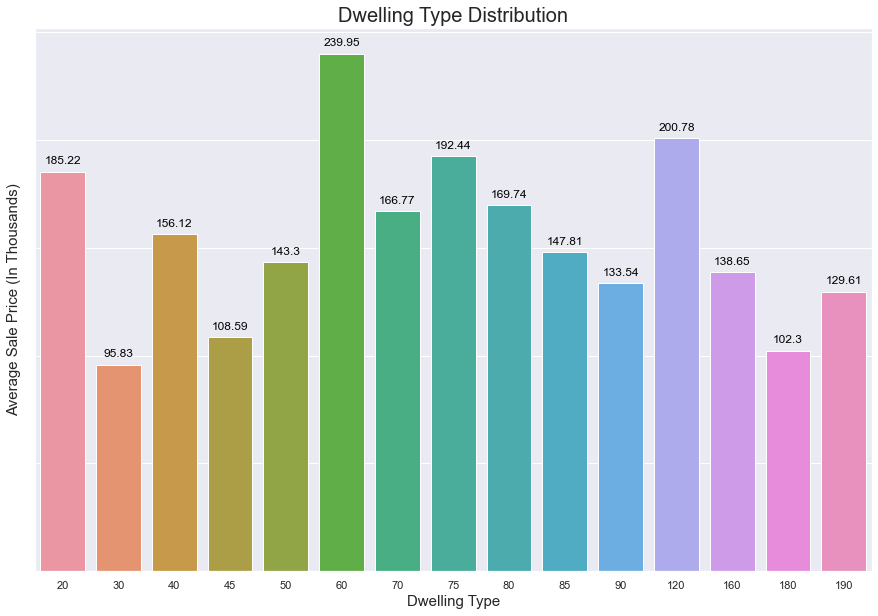

In [2004]:
plot_bar_graph_from_series(data=raw_data.groupby(by='MSSubClass').SalePrice.mean() / 1000,
                           plot_title='Dwelling Type Distribution', x_axis_label='Dwelling Type',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2005]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.MSSubClass, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.08


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.2 Zone Classification

In [2006]:
raw_data.MSZoning.isna().sum()

0

In [2007]:
ms_zone_df = raw_data.MSZoning.value_counts(sort=True)
ms_zone_df

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

#### In the above variable there are 5 unique values of which last three are very scarce . We can avoid creating dummy variable for these variables, as it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 2 values and map all other values as Others

In [2008]:
raw_data.MSZoning = reduce_variable_categorical_nominal(raw_data.MSZoning, 2, 'Others')
raw_data.MSZoning.value_counts(sort=True)

RL        1151
RM         218
Others      91
Name: MSZoning, dtype: int64

#### Zone Classification variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

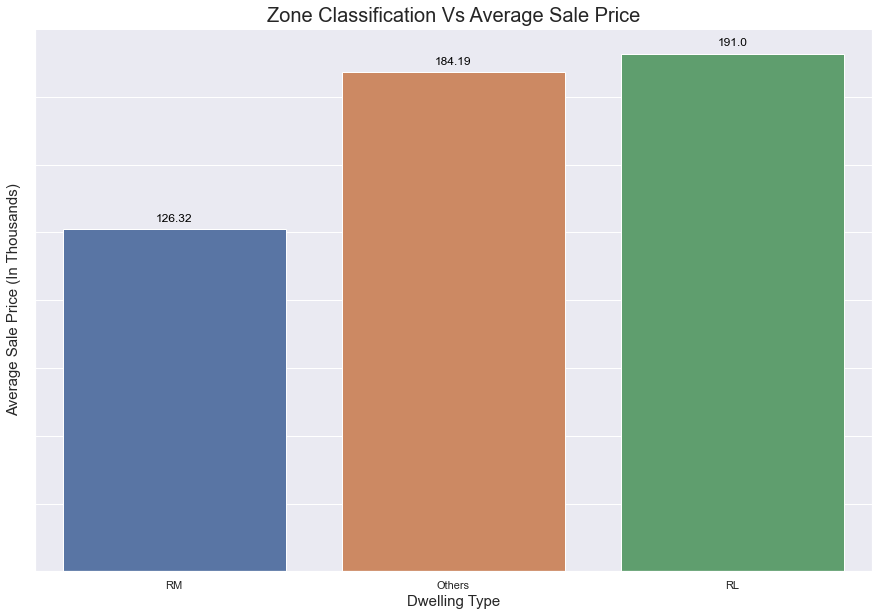

In [2009]:
plot_bar_graph_from_series(data=raw_data.groupby(by='MSZoning').SalePrice.mean().sort_values() / 1000,
                           plot_title='Zone Classification Vs Average Sale Price', x_axis_label='Dwelling Type',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

#### From the above graph, we can say that usually areas with low density tend to attract higher average price

### 4.3 Lot Frontage

In [2010]:
raw_data.LotFrontage.isna().sum()

259

#### Lot Frontage mainly refers to Linear Feet of the Street connected to property.
#### In few cases, we come across scenarios wherein the Lot Frontage is 0 i.e. street is not connected.
#### So for this variable, we will continue marking the missing values i.e. NA with 0

In [2011]:
raw_data.LotFrontage = raw_data.LotFrontage.replace([np.nan], 0)

In [2012]:
raw_data.LotFrontage.isna().sum()

0

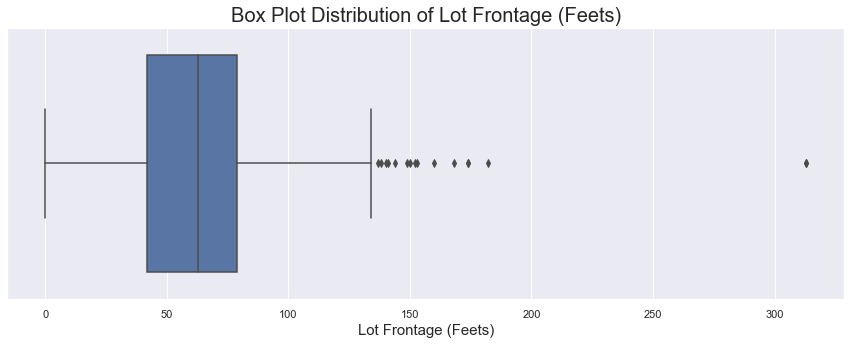

In [2013]:
plot_box_plot_from_series(data=raw_data.LotFrontage,
                          plot_title='Box Plot Distribution of Lot Frontage (Feets)', 
                          x_axis_label='Lot Frontage (Feets)')

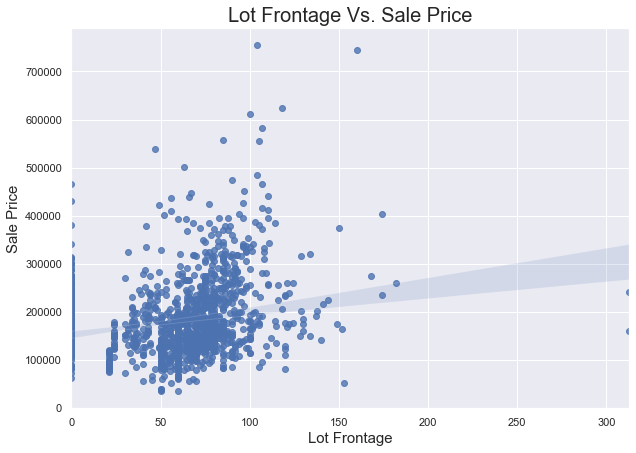

In [2014]:
plot_reg_graph_from_series(x_data=raw_data.LotFrontage, y_data=raw_data.SalePrice, plot_title='Lot Frontage Vs. Sale Price',
                           x_axis_label='Lot Frontage', y_axis_label='Sale Price')

In [2015]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.LotFrontage, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.21


#### From the above correlation value, we can somehow be clear that Lot Frontage Size somehow impact price of the house

### 4.4 Lot Area

In [2016]:
raw_data.LotArea.isna().sum()

0

In [2017]:
raw_data.LotArea.describe(percentiles=np.arange(0, 1.1, 0.1))

count      1460.000000
mean      10516.828082
std        9981.264932
min        1300.000000
0%         1300.000000
10%        5000.000000
20%        7078.400000
30%        8063.700000
40%        8793.400000
50%        9478.500000
60%       10198.200000
70%       11066.500000
80%       12205.800000
90%       14381.700000
100%     215245.000000
max      215245.000000
Name: LotArea, dtype: float64

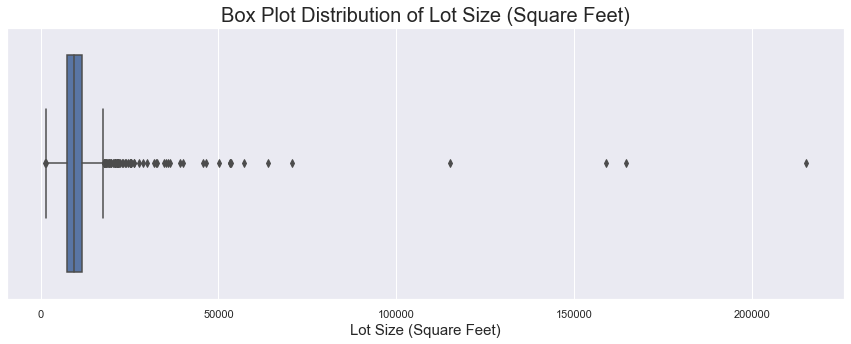

In [2018]:
plot_box_plot_from_series(data=raw_data.LotArea,
                          plot_title='Box Plot Distribution of Lot Size (Square Feet)', 
                          x_axis_label='Lot Size (Square Feet)')

#### Above graph certainly shows that there are few outliers which needs to be handled

#### For this, we will fetch only bottom 99.7% of the values and ignore all the outliers above this value

#### Thereby we are dropping all the outliers beyond the range of 99.7%

In [2019]:
# raw_data = raw_data[raw_data.LotArea < raw_data.LotArea.quantile(0.997)]

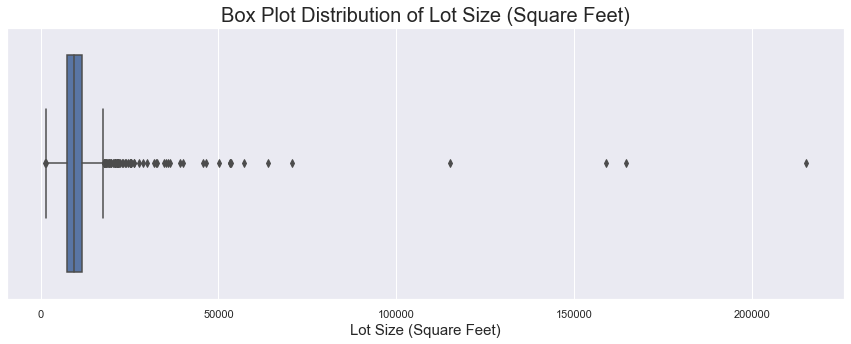

In [2020]:
plot_box_plot_from_series(data=raw_data.LotArea,
                          plot_title='Box Plot Distribution of Lot Size (Square Feet)', 
                          x_axis_label='Lot Size (Square Feet)')

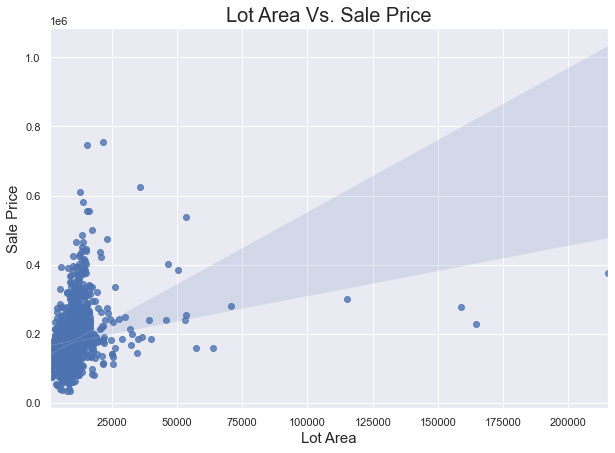

In [2021]:
plot_reg_graph_from_series(x_data=raw_data.LotArea, y_data=raw_data.SalePrice,
                           plot_title='Lot Area Vs. Sale Price', x_axis_label='Lot Area', y_axis_label='Sale Price')

In [2022]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.LotArea, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.26


#### From the above correlation value, we can somehow be clear that Lot Area Size somehow impact price of the house

### 4.5 Street

In [2023]:
raw_data.Street.isna().sum()

0

In [2024]:
street_df = raw_data.Street.value_counts(sort=False)
street_df

Pave    1454
Grvl       6
Name: Street, dtype: int64

#### For the Street Column, more than 99% of values ares same. We can say that this column will not have enough predictive power
#### Owing to this, we can drop this column

In [2025]:
raw_data = raw_data.drop(columns=['Street'])

### 4.6 Alley

In [2026]:
raw_data.Alley.isna().sum()

1369

In [2027]:
alley_df = raw_data.Alley.value_counts(sort=False)
alley_df

Pave    41
Grvl    50
Name: Alley, dtype: int64

#### In this column, null values corresponds to No Alley Access and out of 2 other values, Gravel is usually cheaper than Paved one. So we will impute the values as
- 0: No Alley access
- 1: Gravel
- 2: Paved

In [2028]:
raw_data.Alley = raw_data.Alley.map({np.nan: 0, 'Grvl': 1, 'Pave': 2})

In [2029]:
raw_data.Alley.value_counts(sort=False)

0    1369
1      50
2      41
Name: Alley, dtype: int64

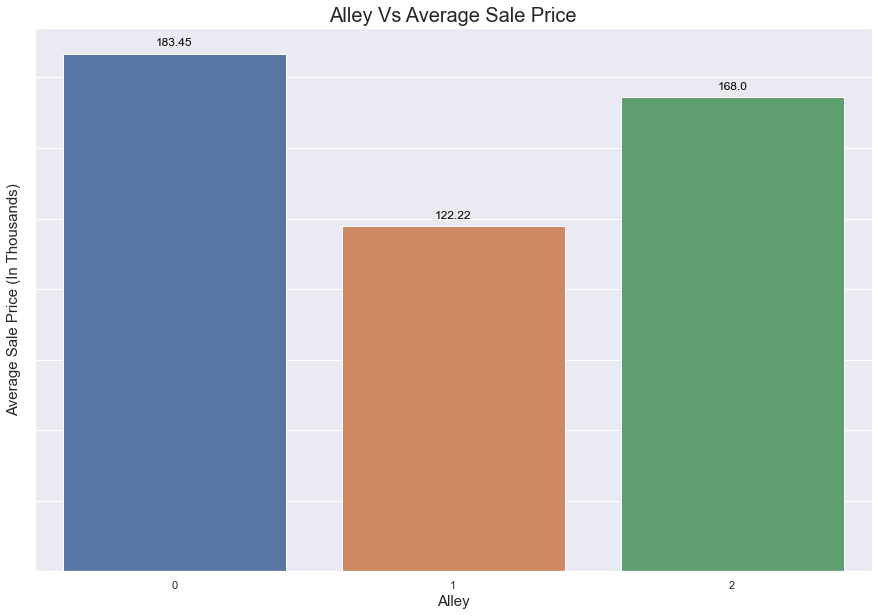

In [2030]:
plot_bar_graph_from_series(data=raw_data.groupby(by='Alley').SalePrice.mean() / 1000,
                           plot_title='Alley Vs Average Sale Price', x_axis_label='Alley',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2031]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.Alley, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.09


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.7 Lot Shape

In [2032]:
raw_data.LotShape.isna().sum()

0

In [2033]:
lot_shape_df = raw_data.LotShape.value_counts(sort=False)
lot_shape_df

IR2     41
Reg    925
IR3     10
IR1    484
Name: LotShape, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2034]:
raw_data.LotShape = raw_data.LotShape.map({'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3})

In [2035]:
raw_data.LotShape.value_counts(sort=False)

0     10
1     41
2    484
3    925
Name: LotShape, dtype: int64

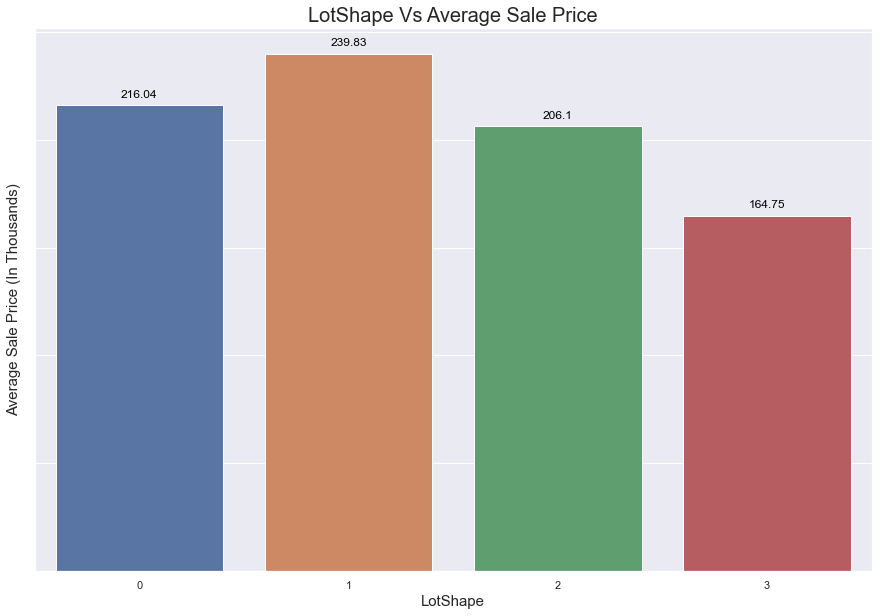

In [2036]:
plot_bar_graph_from_series(data=raw_data.groupby(by='LotShape').SalePrice.mean() / 1000,
                           plot_title='LotShape Vs Average Sale Price', x_axis_label='LotShape',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2037]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.LotShape, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.27


#### From the above correlation value, we can somehow be clear that Lot Shape somehow impact price of the house, although in negative way

### 4.8 Land Contour

In [2038]:
raw_data.LandContour.isna().sum()

0

In [2039]:
land_cont_df = raw_data.LandContour.value_counts(sort=False)
land_cont_df

Low      36
HLS      50
Bnk      63
Lvl    1311
Name: LandContour, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2040]:
raw_data.LandContour = raw_data.LandContour.map({'Low': 0, 'HLS': 1, 'Bnk': 2, 'Lvl': 3})

In [2041]:
raw_data.LandContour.value_counts(sort=False)

0      36
1      50
2      63
3    1311
Name: LandContour, dtype: int64

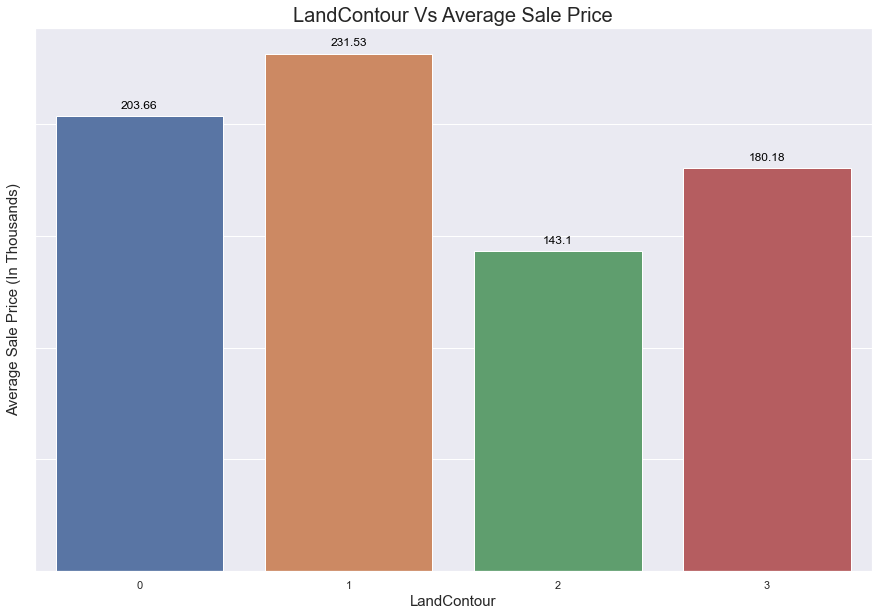

In [2042]:
plot_bar_graph_from_series(data=raw_data.groupby(by='LandContour').SalePrice.mean() / 1000,
                           plot_title='LandContour Vs Average Sale Price', x_axis_label='LandContour',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2043]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.LandContour, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.07


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.9 Utiltities

In [2044]:
raw_data.Utilities.isna().sum()

0

In [2045]:
utility_df = raw_data.Utilities.value_counts(sort=False)
utility_df

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

#### For the Utilities Column, almost 99.99% of values ares same. We can say that this column will not have enough predictive power
#### Owing to this, we can drop this column

In [2046]:
raw_data = raw_data.drop(columns=['Utilities'])

### 4.10 Lot Configuration

In [2047]:
raw_data.LotConfig.isna().sum()

0

In [2048]:
lot_config_df = raw_data.LotConfig.value_counts(sort=True)
lot_config_df

Inside     1052
Corner      263
CulDSac      94
FR2          47
FR3           4
Name: LotConfig, dtype: int64

#### In the above variable there are 5 unique values of which last 2 are very scarce . We can avoid creating dummy variable for these variables, as it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 3 values and map all other values as Others

In [2049]:
raw_data.LotConfig = reduce_variable_categorical_nominal(raw_data.LotConfig, 3)
raw_data.LotConfig.value_counts(sort=True)

Inside     1052
Corner      263
CulDSac      94
Others       51
Name: LotConfig, dtype: int64

#### Lot Configuration varibale do not hold any order. So, this variable can be used as Categorical Nominal Variable

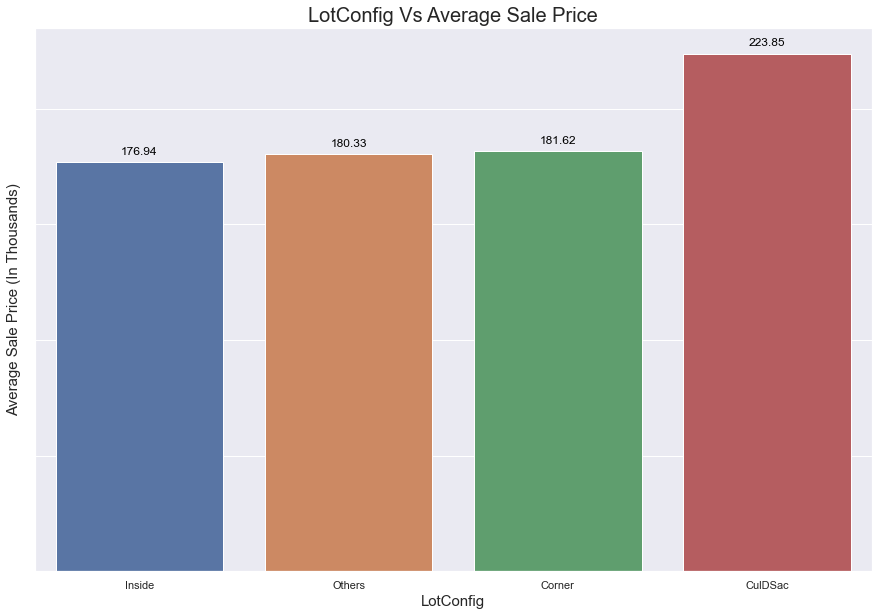

In [2050]:
plot_bar_graph_from_series(data=raw_data.groupby(by='LotConfig').SalePrice.mean().sort_values() / 1000,
                           plot_title='LotConfig Vs Average Sale Price', x_axis_label='LotConfig',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

#### No form of pattern is observed in Sale Price with respect to Lot Configuration

### 4.11 Land Slope

In [2051]:
land_slope_df = raw_data.LandSlope.value_counts(sort=False)
land_slope_df

Mod      65
Gtl    1382
Sev      13
Name: LandSlope, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2052]:
raw_data.LandSlope = raw_data.LandSlope.map({'Gtl': 0, 'Mod': 1, 'Sev': 2})

In [2053]:
raw_data.LandSlope.value_counts(sort=False)

0    1382
1      65
2      13
Name: LandSlope, dtype: int64

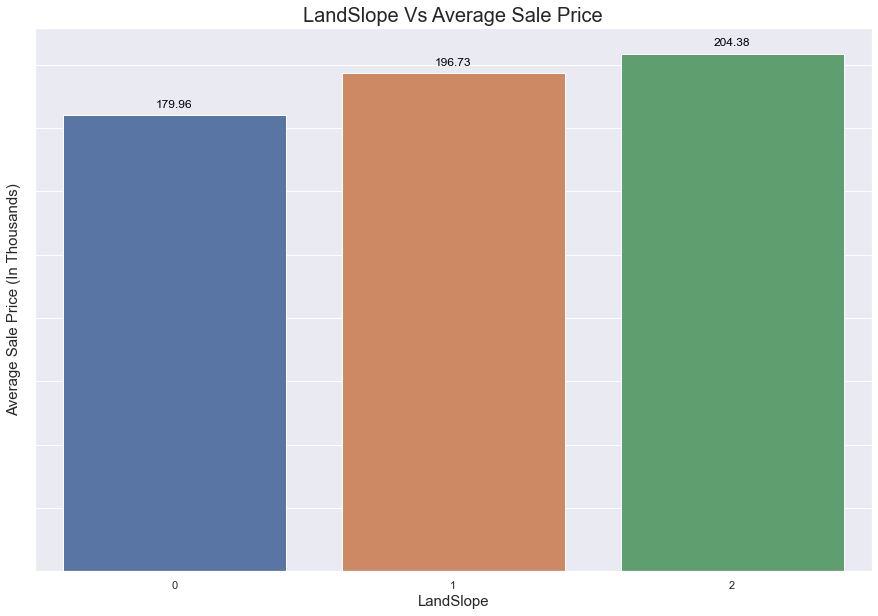

In [2054]:
plot_bar_graph_from_series(data=raw_data.groupby(by='LandSlope').SalePrice.mean() / 1000,
                           plot_title='LandSlope Vs Average Sale Price', x_axis_label='LandSlope',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2055]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.LandSlope, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.05


### 4.12 Neighbourhood

In [2056]:
neighbourhood_df = raw_data.Neighborhood.value_counts(sort=True)
neighbourhood_df

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

#### Neighbourhood variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

#### In the above variable there are more than 25 unique values. If we create dummy variable for each of this, it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 10 values and map all other values to 0

In [2057]:
raw_data.Neighborhood = reduce_variable_categorical_nominal(raw_data.Neighborhood, 10)

In [2058]:
raw_data.Neighborhood.value_counts(sort=True)

Others     424
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
Name: Neighborhood, dtype: int64

### 4.13 Condition 1

In [2059]:
raw_data.Condition1.isna().sum()

0

In [2060]:
condition_1_df = raw_data.Condition1.value_counts(sort=True)
condition_1_df

Norm      1260
Feedr       81
Artery      48
RRAn        26
PosN        19
RRAe        11
PosA         8
RRNn         5
RRNe         2
Name: Condition1, dtype: int64

#### In the above variable there are 9 unique values of which last 7 are very scarce . We can avoid creating dummy variable for these variables, as it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 2 values and map all other values as Others

In [2061]:
raw_data.Condition1 = reduce_variable_categorical_nominal(raw_data.Condition1, 3)
raw_data.Condition1.value_counts(sort=True)

Norm      1260
Feedr       81
Others      71
Artery      48
Name: Condition1, dtype: int64

#### There is no specific order involved with this variable. We shall classify this as categorical nominal variable

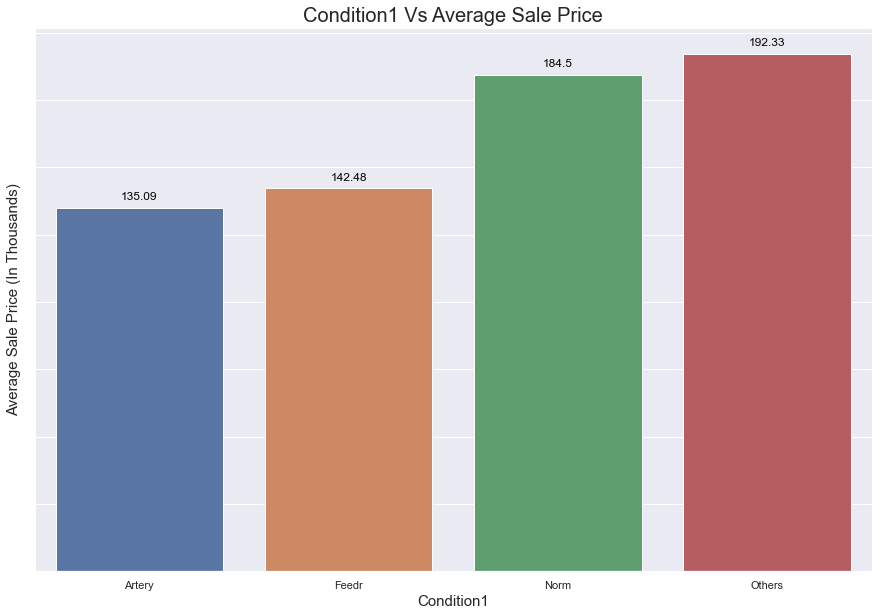

In [2062]:
plot_bar_graph_from_series(data=raw_data.groupby(by='Condition1').SalePrice.mean().sort_values() / 1000,
                           plot_title='Condition1 Vs Average Sale Price', x_axis_label='Condition1',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

#### Average Sale price house is usually low besides high capacity urban roads like highways, freeways or nearby railroads and higher price near parks, greenbelts etc.

### 4.14 Condition 2

In [2063]:
raw_data.Condition2.isna().sum()

0

In [2064]:
condition_2_df = raw_data.Condition2.value_counts(sort=True)
condition_2_df

Norm      1445
Feedr        6
Artery       2
RRNn         2
PosN         2
RRAn         1
PosA         1
RRAe         1
Name: Condition2, dtype: int64

#### For the Condition 2 Column, since 99% of values ares same we can say that this column will not have enough predictive power
#### Owing to this, we can drop this column and concentrate only on Condition 1 column

In [2065]:
raw_data = raw_data.drop(columns=['Condition2'])

In [2066]:
raw_data.shape

(1460, 77)

### 4.15 Building Type

In [2067]:
raw_data.BldgType.isna().sum()

0

In [2068]:
building_type_df = raw_data.BldgType.value_counts(sort=True)
building_type_df

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

#### Building Type varibale do not hold any order. So, this variable can be used as Categorical Nominal Variable

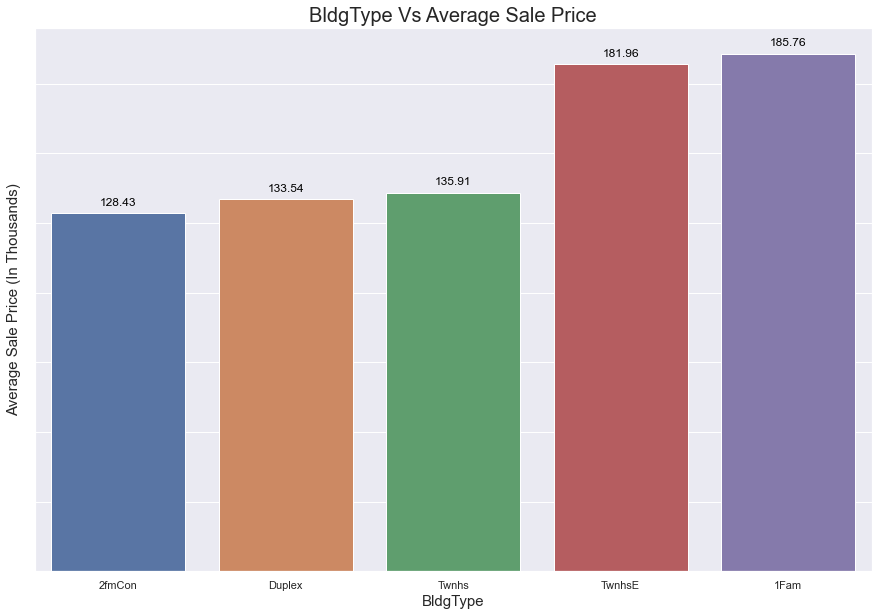

In [2069]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BldgType').SalePrice.mean().sort_values() / 1000,
                           plot_title='BldgType Vs Average Sale Price', x_axis_label='BldgType',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

### 4.16 House Style

In [2070]:
raw_data.HouseStyle.isna().sum()

0

In [2071]:
housing_style_df = raw_data.HouseStyle.value_counts(sort=True)
housing_style_df

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

#### House Style varibale do not hold any order. So, this variable can be used as Categorical Nominal Variable

#### In the above variable there are 8 unique values of which last three are very scarce . We can avoid creating dummy variable for these variables, as it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 3 values and map all other values as Others

In [2072]:
raw_data.HouseStyle = reduce_variable_categorical_nominal(raw_data.HouseStyle, 3)
raw_data.HouseStyle.value_counts(sort=True)

1Story    726
2Story    445
1.5Fin    154
Others    135
Name: HouseStyle, dtype: int64

### 4.17 Overall Quality

In [2073]:
raw_data.OverallQual.isna().sum()

0

In [2074]:
overall_quality_df = raw_data.OverallQual.value_counts(sort=False)
overall_quality_df

1       2
2       3
3      20
4     116
5     397
6     374
7     319
8     168
9      43
10     18
Name: OverallQual, dtype: int64

#### This variable can be considered as categorical ordinal variable.

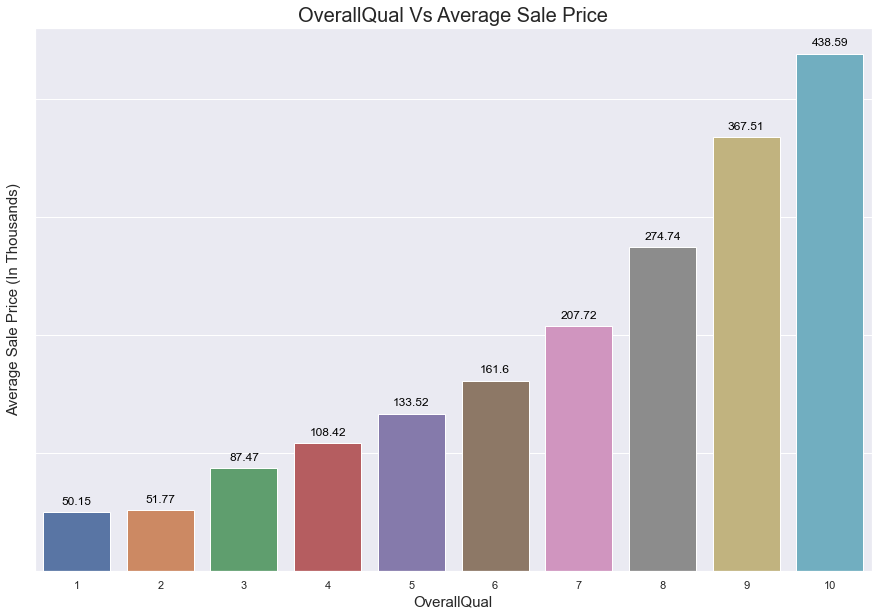

In [2075]:
plot_bar_graph_from_series(data=raw_data.groupby(by='OverallQual').SalePrice.mean() / 1000,
                           plot_title='OverallQual Vs Average Sale Price', x_axis_label='OverallQual',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2076]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.OverallQual, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.79


#### From the above correlation value, we can be clear that Overall Property Quality impact price of the house significantly

### 4.18 Overall Condition

In [2077]:
raw_data.OverallCond.isna().sum()

0

In [2078]:
overall_cond_df = raw_data.OverallCond.value_counts(sort=False)
overall_cond_df

1      1
2      5
3     25
4     57
5    821
6    252
7    205
8     72
9     22
Name: OverallCond, dtype: int64

#### This variable can be considered as categorical ordinal variable.

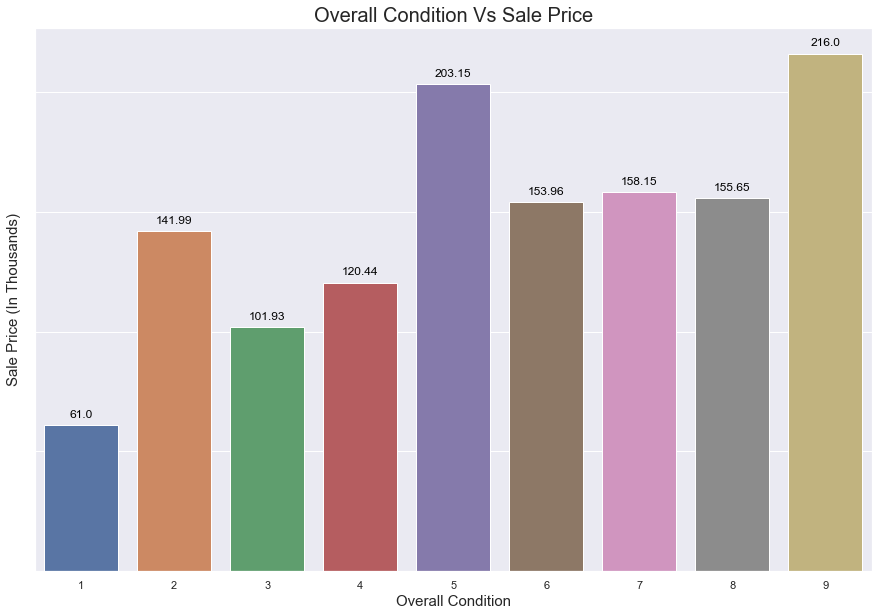

In [2079]:
plot_bar_graph_from_series(data=raw_data.groupby(by='OverallCond').SalePrice.mean() / 1000,
                           plot_title='Overall Condition Vs Sale Price', x_axis_label='Overall Condition',
                           y_axis_label='Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2080]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.OverallCond, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.08


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.19 Year Built

In [2081]:
raw_data.YearBuilt.isna().sum()

0

In [2082]:
year_df = raw_data.YearBuilt.value_counts(sort=False)
year_df

1872     1
1875     1
1880     4
1882     1
1885     2
        ..
2006    67
2007    49
2008    23
2009    18
2010     1
Name: YearBuilt, Length: 112, dtype: int64

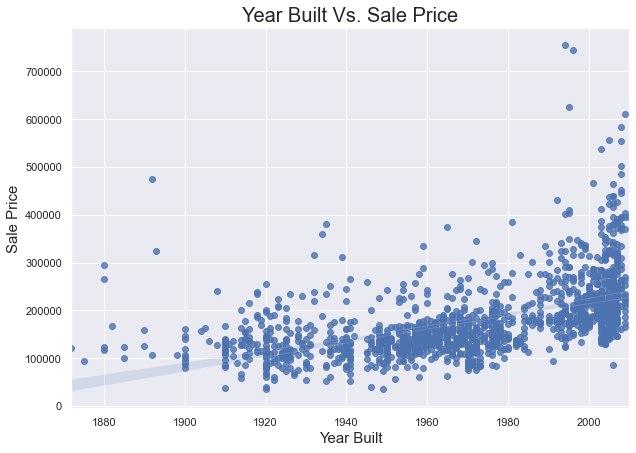

In [2083]:
plot_reg_graph_from_series(x_data=raw_data.YearBuilt, y_data=raw_data.SalePrice, plot_title='Year Built Vs. Sale Price',
                           x_axis_label='Year Built', y_axis_label='Sale Price')

In [2084]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.YearBuilt, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.52


#### From the above correlation value, we can be clear that Year on which Property was built impacts price of the house significantly

### 4.20 Remodel Year

In [2085]:
raw_data.YearRemodAdd.isna().sum()

0

In [2086]:
remodel_year_df = raw_data.YearRemodAdd.value_counts(sort=False)
remodel_year_df

1950    178
1951      4
1952      5
1953     10
1954     14
       ... 
2006     97
2007     76
2008     40
2009     23
2010      6
Name: YearRemodAdd, Length: 61, dtype: int64

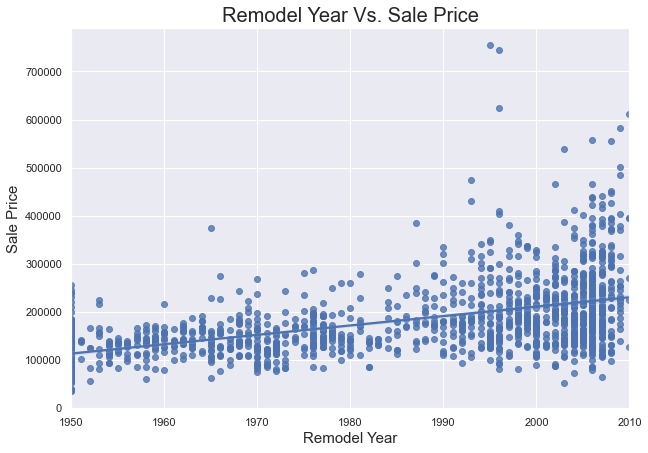

In [2087]:
plot_reg_graph_from_series(x_data=raw_data.YearRemodAdd, y_data=raw_data.SalePrice, plot_title='Remodel Year Vs. Sale Price',
                           x_axis_label='Remodel Year', y_axis_label='Sale Price')

In [2088]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.YearRemodAdd, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.51


#### From the above correlation value, we can be clear that Year on which Property was remodeled impacts price of the house significantly

### 4.21 Roof Style

In [2089]:
raw_data.RoofStyle.isna().sum()

0

In [2090]:
roof_style_df = raw_data.RoofStyle.value_counts(sort=True)
roof_style_df

Gable      1141
Hip         286
Flat         13
Gambrel      11
Mansard       7
Shed          2
Name: RoofStyle, dtype: int64

#### Roof Style variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

#### In the above variable there are 6 unique values of which last three are very scarce . We can avoid creating dummy variable for these variables, as it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 2 values and map all other values as Others

In [2091]:
raw_data.RoofStyle = reduce_variable_categorical_nominal(raw_data.RoofStyle, 2)
raw_data.RoofStyle.value_counts(sort=True)

Gable     1141
Hip        286
Others      33
Name: RoofStyle, dtype: int64

### 4.22 Roof Material

In [2092]:
raw_data.RoofMatl.isna().sum()

0

In [2093]:
roof_mat_df = raw_data.RoofMatl.value_counts(sort=True)
roof_mat_df

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
ClyTile       1
Metal         1
Roll          1
Membran       1
Name: RoofMatl, dtype: int64

#### For the Roof Material, more than 98% of values ares same. We can say that this column will not have enough predictive power
#### Owing to this, we can drop this column

In [2094]:
raw_data = raw_data.drop(columns=['RoofMatl'])

### 4.23 Exterior covering on house (Exterior1st)

In [2095]:
raw_data.Exterior1st.isna().sum()

0

In [2096]:
ext1_df = raw_data.Exterior1st.value_counts(sort=True)
ext1_df

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
Stone        2
BrkComm      2
ImStucc      1
CBlock       1
AsphShn      1
Name: Exterior1st, dtype: int64

#### Exterior1st variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

#### In the above variable there are more than 15 unique values. If we create dummy variable for each of this, it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 5 values and ignore lesser values

In [2097]:
raw_data.Exterior1st = reduce_variable_categorical_nominal(raw_data.Exterior1st, 5, 'Others')

In [2098]:
raw_data.Exterior1st.value_counts(sort=True)

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Others     189
Plywood    108
Name: Exterior1st, dtype: int64

### 4.24 Exterior covering on house - If more than 1 Material (Exterior2nd)

In [2099]:
raw_data.Exterior2nd.isna().sum()

0

In [2100]:
ext2_df = raw_data.Exterior2nd.value_counts(sort=True)
ext2_df

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

#### Exterior2nd variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

#### In the above variable there are more than 15 unique values. If we create dummy variable for each of this, it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 5 values and ignore lesser values

In [2101]:
raw_data.Exterior2nd = reduce_variable_categorical_nominal(raw_data.Exterior2nd, 5, 'Others')

In [2102]:
raw_data.Exterior2nd.value_counts(sort=True)

VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Others     196
Plywood    142
Name: Exterior2nd, dtype: int64

### 4.25 Masonry veneer type (MasVnrType)

In [2103]:
raw_data.MasVnrType.isna().sum()

8

In [2104]:
mas_vnr_type_df = raw_data.MasVnrType.value_counts(sort=False)
mas_vnr_type_df

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

#### All the rows corresponding missing 8 values in this column shall be dropped for better further analysis

In [2105]:
raw_data = raw_data.dropna(subset=['MasVnrType'])

#### Masonry veneer type variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

### 4.26 Masonry veneer area

In [2106]:
raw_data.MasVnrArea.isna().sum()

0

In [2107]:
mas_ven_df = raw_data.MasVnrArea.value_counts(sort=False)
mas_ven_df

196.0      4
0.0      861
186.0      3
240.0      3
212.0      2
        ... 
630.0      1
425.0      2
423.0      2
567.0      1
621.0      1
Name: MasVnrArea, Length: 327, dtype: int64

#### This variable can be considered as continuous variable

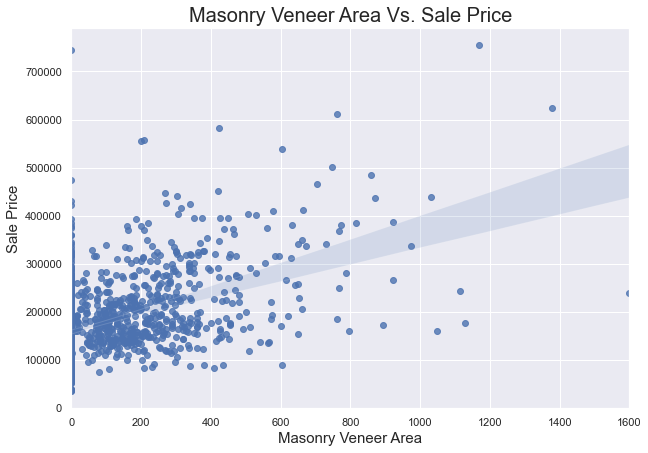

In [2108]:
plot_reg_graph_from_series(x_data=raw_data.MasVnrArea, y_data=raw_data.SalePrice, plot_title='Masonry Veneer Area Vs. Sale Price',
                           x_axis_label='Masonry Veneer Area', y_axis_label='Sale Price')

In [2109]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.MasVnrArea, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.48


#### From the above correlation value, we can be clear that Masonry Vineer Area impacts price of the house significantly

### 4.27 Exterior Material Quality

In [2110]:
raw_data.ExterQual.isna().sum()

0

In [2111]:
ext_qua_df = raw_data.ExterQual.value_counts(sort=False)
ext_qua_df

Ex     51
TA    906
Fa     14
Gd    481
Name: ExterQual, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2112]:
raw_data.ExterQual = raw_data.ExterQual.map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})

In [2113]:
raw_data.ExterQual.value_counts(sort=False)

1     14
2    906
3    481
4     51
Name: ExterQual, dtype: int64

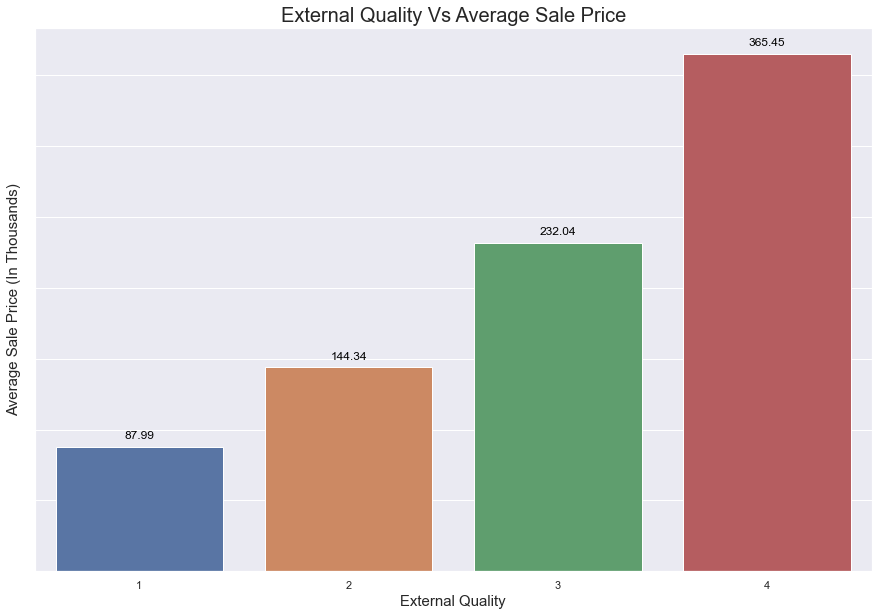

In [2114]:
plot_bar_graph_from_series(data=raw_data.groupby(by='ExterQual').SalePrice.mean() / 1000,
                           plot_title='External Quality Vs Average Sale Price', x_axis_label='External Quality',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2115]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.ExterQual, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.68


#### From the above correlation value, we can be clear that External Quality of Property impacts price of the house significantly

### 4.28 Exterior Material Present Quality

In [2116]:
raw_data.ExterCond.isna().sum()

0

In [2117]:
ext_qua_p_df = raw_data.ExterCond.value_counts(sort=False)
ext_qua_p_df

Ex       3
TA    1274
Fa      28
Po       1
Gd     146
Name: ExterCond, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2118]:
raw_data.ExterCond = raw_data.ExterCond.map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})

In [2119]:
raw_data.ExterCond.value_counts(sort=False)

0       1
1      28
2    1274
3     146
4       3
Name: ExterCond, dtype: int64

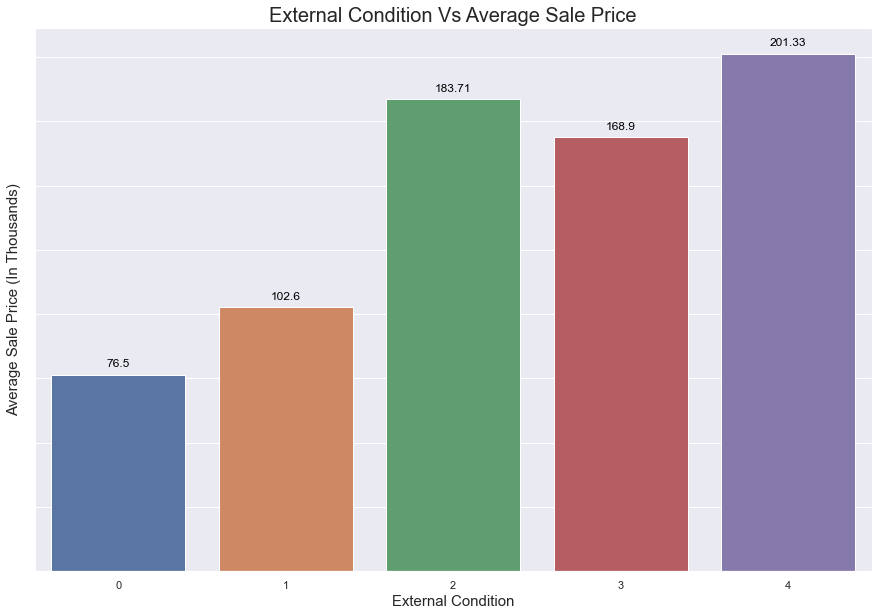

In [2120]:
plot_bar_graph_from_series(data=raw_data.groupby(by='ExterCond').SalePrice.mean() / 1000,
                           plot_title='External Condition Vs Average Sale Price', x_axis_label='External Condition',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2121]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.ExterCond, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.02


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.29 Foundation Type

In [2122]:
raw_data.Foundation.isna().sum()

0

In [2123]:
found_type_df = raw_data.Foundation.value_counts(sort=True)
found_type_df

PConc     639
CBlock    634
BrkTil    146
Slab       24
Stone       6
Wood        3
Name: Foundation, dtype: int64

#### Foundation Type variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

#### In the above variable there are 6 unique values of which last three are very scarce . We can avoid creating dummy variable for these variables, as it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 3 values and map all other values as Others

In [2124]:
raw_data.Foundation = reduce_variable_categorical_nominal(raw_data.Foundation, 3)
raw_data.Foundation.value_counts(sort=True)

PConc     639
CBlock    634
BrkTil    146
Others     33
Name: Foundation, dtype: int64

### 4.30 Basement Quality

In [2125]:
raw_data.BsmtQual.isna().sum()

37

In [2126]:
base_qual_df = raw_data.BsmtQual.value_counts(sort=False)
base_qual_df

Ex    120
TA    648
Fa     35
Gd    612
Name: BsmtQual, dtype: int64

#### Null values on this column are actually the apartments with no basement. So we will map these null values to -1

#### Being a categorical ordinal variable, following values will be imputed

In [2127]:
raw_data.BsmtQual = raw_data.BsmtQual.map({np.nan: -1, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [2128]:
raw_data.BsmtQual.value_counts(sort=False)

-1     37
 2     35
 3    648
 4    612
 5    120
Name: BsmtQual, dtype: int64

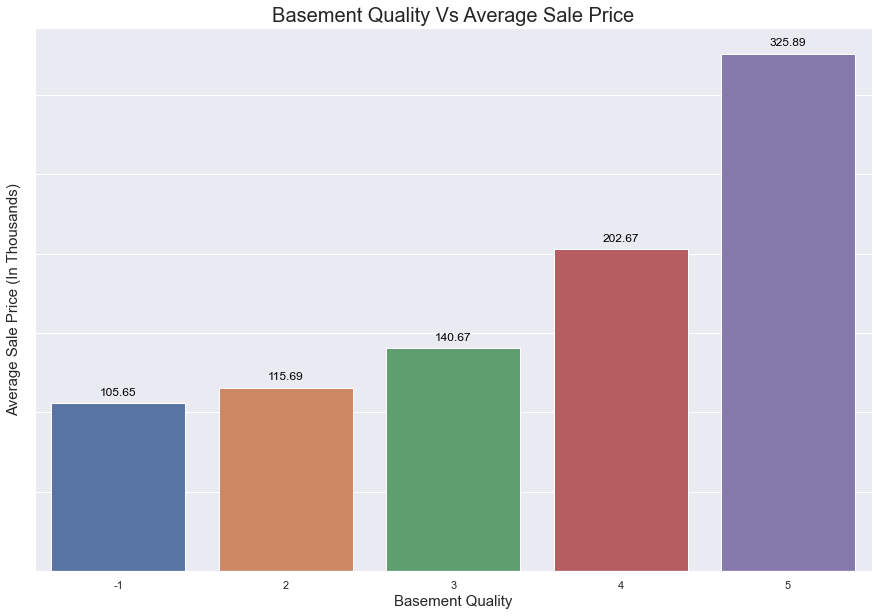

In [2129]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BsmtQual').SalePrice.mean() / 1000,
                           plot_title='Basement Quality Vs Average Sale Price', x_axis_label='Basement Quality',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2130]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtQual, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.54


#### From the above correlation value, we can be clear that Basement Quality impacts price of the house significantly

### 4.31 Basement Condition

In [2131]:
raw_data.BsmtCond.isna().sum()

37

In [2132]:
base_cond_df = raw_data.BsmtCond.value_counts(sort=False)
base_cond_df

TA    1304
Fa      45
Po       2
Gd      64
Name: BsmtCond, dtype: int64

#### Null values on this column are actually the apartments with no basement. So we will map these null values to -1

#### Being a categorical ordinal variable, following values will be imputed

In [2133]:
raw_data.BsmtCond = raw_data.BsmtCond.map({np.nan: -1, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [2134]:
raw_data.BsmtCond.value_counts(sort=False)

-1      37
 1       2
 2      45
 3    1304
 4      64
Name: BsmtCond, dtype: int64

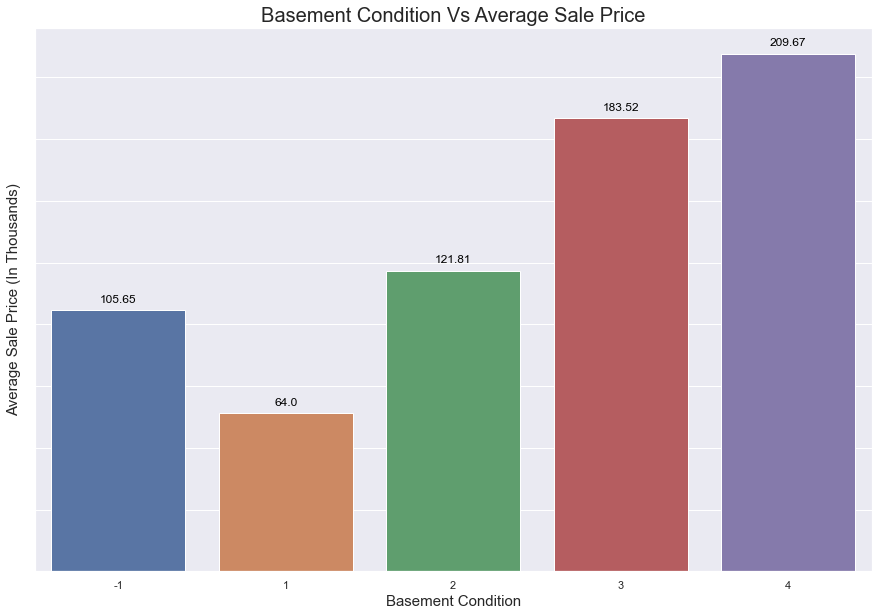

In [2135]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BsmtCond').SalePrice.mean() / 1000,
                           plot_title='Basement Condition Vs Average Sale Price', x_axis_label='Basement Condition',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2136]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtCond, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.20


#### From the above correlation value, we can somehow be clear that Basement Condition somehow impact price of the house

### 4.32 Basement Exposure

In [2137]:
raw_data.BsmtExposure.isna().sum()

38

In [2138]:
base_exp_df = raw_data.BsmtExposure.value_counts(sort=False)
base_exp_df

Av    221
No    946
Mn    114
Gd    133
Name: BsmtExposure, dtype: int64

#### Null values on this column are actually the apartments with no basement, hence exposure will also be -1. Thus, we will map these null values to 0 (least value)

#### Being a categorical ordinal variable, following values will be imputed

In [2139]:
raw_data.BsmtExposure = raw_data.BsmtExposure.map({np.nan: -1, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4})

In [2140]:
raw_data.BsmtExposure.value_counts(sort=False)

-1     38
 1    946
 2    114
 3    221
 4    133
Name: BsmtExposure, dtype: int64

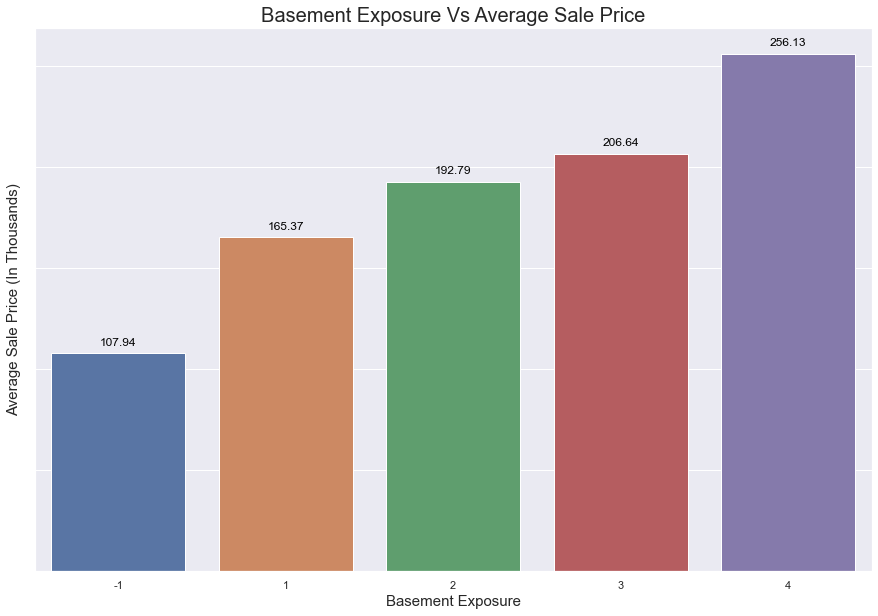

In [2141]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BsmtExposure').SalePrice.mean() / 1000,
                           plot_title='Basement Exposure Vs Average Sale Price', x_axis_label='Basement Exposure',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2142]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtExposure, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.38


#### From the above correlation value, we can be clear that Basement Exposure impacts price of the house significantly

### 4.33 Basement Finished Area Ratings

In [2143]:
raw_data.BsmtFinType1.isna().sum()

37

In [2144]:
base_fin_df = raw_data.BsmtFinType1.value_counts(sort=False)
base_fin_df

GLQ    413
Unf    428
LwQ     74
ALQ    220
Rec    132
BLQ    148
Name: BsmtFinType1, dtype: int64

#### Null values on this column are actually the apartments with no basement, hence finished rating will also be -1. Thus, we will map these null values to 0 (least value)

#### Being a categorical ordinal variable, following values will be imputed

In [2145]:
raw_data.BsmtFinType1 = raw_data.BsmtFinType1.map({np.nan: -1, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6})

In [2146]:
raw_data.BsmtFinType1.value_counts(sort=False)

-1     37
 1    428
 2     74
 3    132
 4    148
 5    220
 6    413
Name: BsmtFinType1, dtype: int64

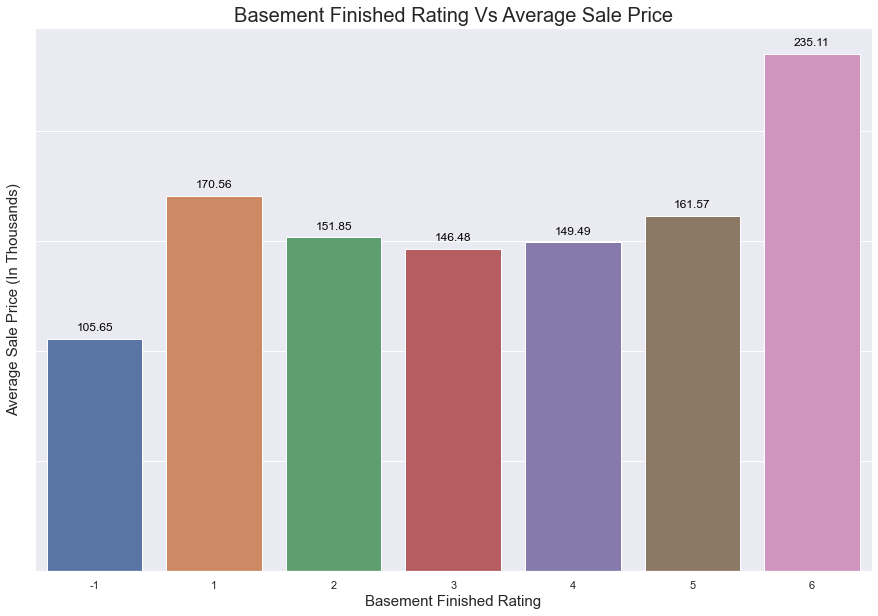

In [2147]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BsmtFinType1').SalePrice.mean() / 1000,
                           plot_title='Basement Finished Rating Vs Average Sale Price', x_axis_label='Basement Finished Rating',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2148]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtFinType1, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.31


#### From the above correlation value, we can be clear that Basement Finished Ratings impacts price of the house significantly

### 4.34 Type 1 finished square feet

In [2149]:
raw_data.BsmtFinSF1.isna().sum()

0

#### This variable can be considered as continuous variable

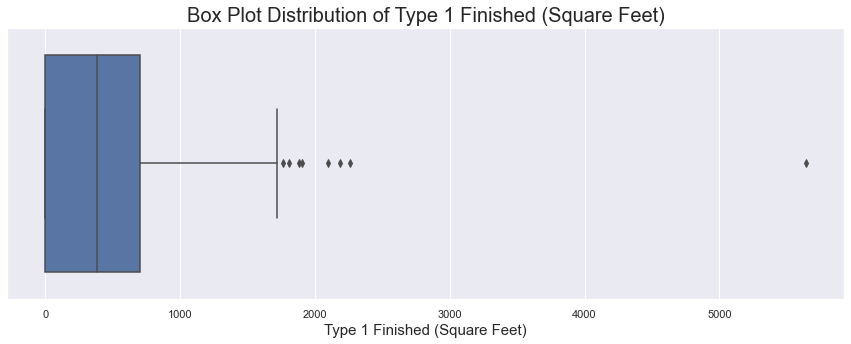

In [2150]:
plot_box_plot_from_series(data=raw_data.BsmtFinSF1,
                          plot_title='Box Plot Distribution of Type 1 Finished (Square Feet)', 
                          x_axis_label='Type 1 Finished (Square Feet)')

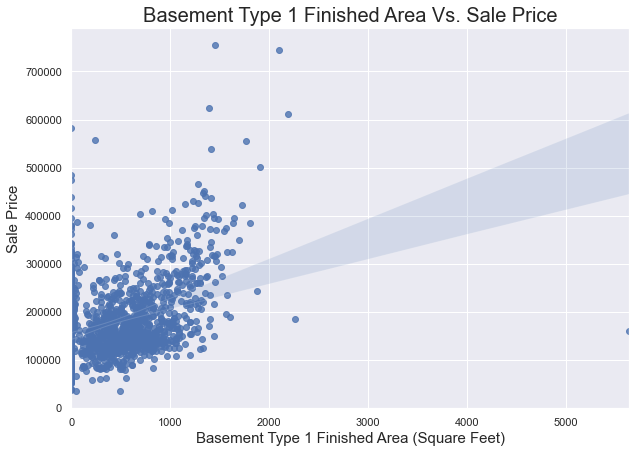

In [2151]:
plot_reg_graph_from_series(x_data=raw_data.BsmtFinSF1, y_data=raw_data.SalePrice,
                           plot_title='Basement Type 1 Finished Area Vs. Sale Price',
                           x_axis_label='Basement Type 1 Finished Area (Square Feet)', y_axis_label='Sale Price')

In [2152]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtFinSF1, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.38


#### From the above correlation value, we can be clear that Basement Type 1 Finished Area impacts price of the house significantly

### 4.35 Basement Finished Area Ratings (if multiple types)

In [2153]:
raw_data.BsmtFinType2.isna().sum()

38

In [2154]:
base_fin_2_df = raw_data.BsmtFinType2.value_counts(sort=False)
base_fin_2_df

GLQ      14
Unf    1248
LwQ      46
ALQ      19
Rec      54
BLQ      33
Name: BsmtFinType2, dtype: int64

#### Null values on this column are actually the apartments with no multiple basements, hence finished rating will also be -1. Thus, we will map these null values to 0 (least value)

#### Being a categorical ordinal variable, following values will be imputed

In [2155]:
raw_data.BsmtFinType2 = raw_data.BsmtFinType2.map({np.nan: -1, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6})

In [2156]:
raw_data.BsmtFinType2.value_counts(sort=False)

-1      38
 1    1248
 2      46
 3      54
 4      33
 5      19
 6      14
Name: BsmtFinType2, dtype: int64

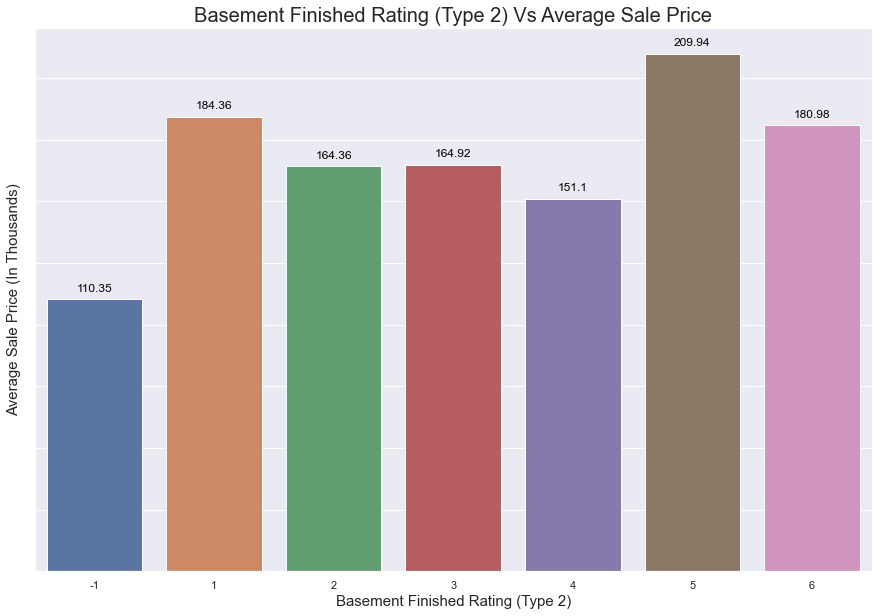

In [2157]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BsmtFinType2').SalePrice.mean() / 1000,
                           plot_title='Basement Finished Rating (Type 2) Vs Average Sale Price',
                           x_axis_label='Basement Finished Rating (Type 2)',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2158]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtFinType2, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.02


#### Correlation Co-efficient of Sale Price with this variable is 0 indicating no relation

### 4.36 Type 2 Finished (Square feet)

In [2159]:
raw_data.BsmtFinSF2.isna().sum()

0

#### This variable can be considered as continuous variable

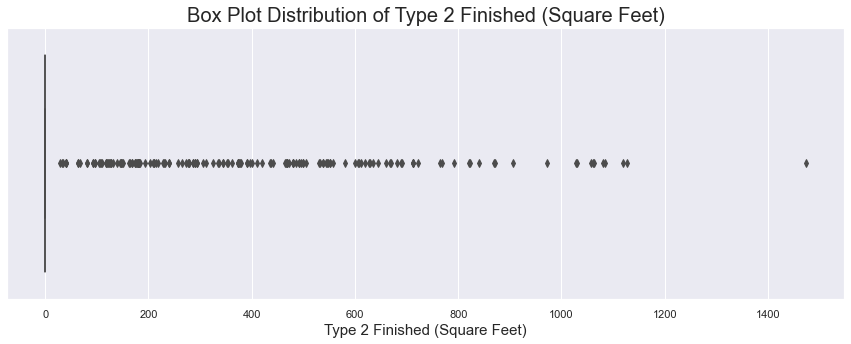

In [2160]:
plot_box_plot_from_series(data=raw_data.BsmtFinSF2,
                          plot_title='Box Plot Distribution of Type 2 Finished (Square Feet)', 
                          x_axis_label='Type 2 Finished (Square Feet)')

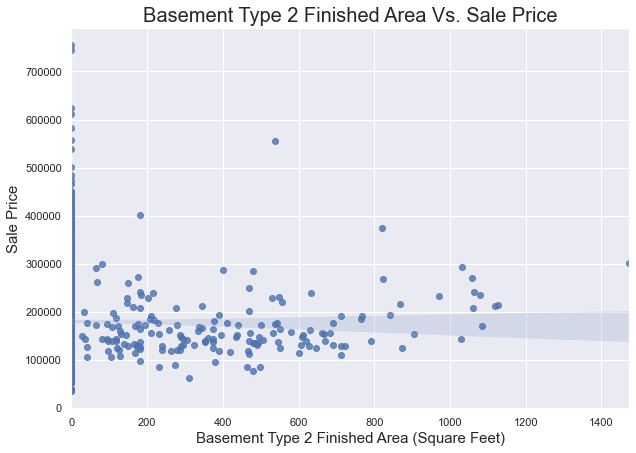

In [2161]:
plot_reg_graph_from_series(x_data=raw_data.BsmtFinSF2, y_data=raw_data.SalePrice,
                           plot_title='Basement Type 2 Finished Area Vs. Sale Price',
                           x_axis_label='Basement Type 2 Finished Area (Square Feet)', y_axis_label='Sale Price')

In [2162]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtFinSF2, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.01


#### Correlation Co-efficient of Sale Price with this variable is almost 0 indicating almost no relation

### 4.37 Unfinished Square Feet of Basement Area

In [2163]:
raw_data.BsmtUnfSF.isna().sum()

0

#### This variable can be considered as continuous variable

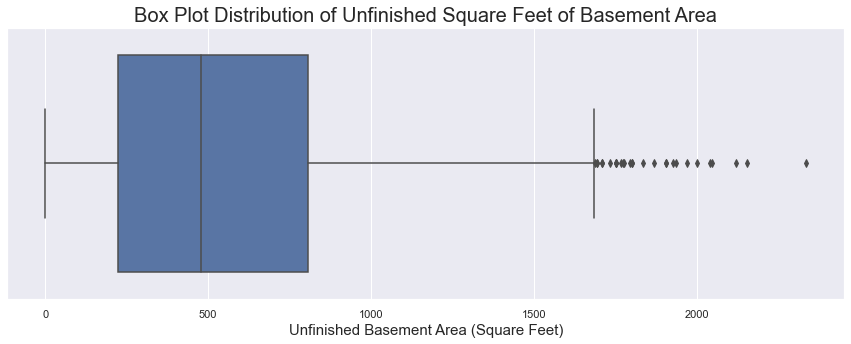

In [2164]:
plot_box_plot_from_series(data=raw_data.BsmtUnfSF,
                          plot_title='Box Plot Distribution of Unfinished Square Feet of Basement Area', 
                          x_axis_label='Unfinished Basement Area (Square Feet)')

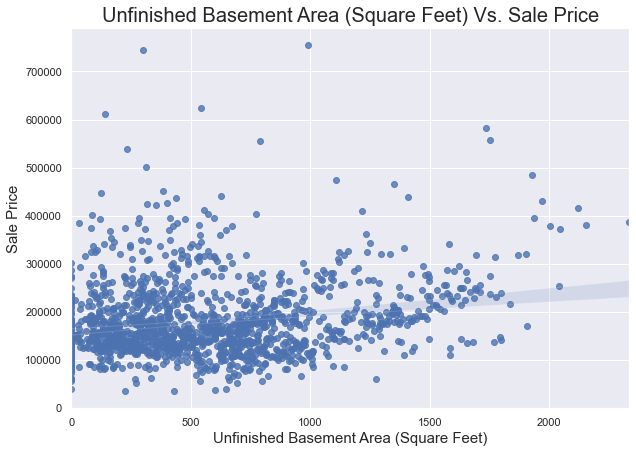

In [2165]:
plot_reg_graph_from_series(x_data=raw_data.BsmtUnfSF, y_data=raw_data.SalePrice,
                           plot_title='Unfinished Basement Area (Square Feet) Vs. Sale Price',
                           x_axis_label='Unfinished Basement Area (Square Feet)', y_axis_label='Sale Price')

In [2166]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtUnfSF, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.22


#### From the above correlation value, we can somehow be clear that Unfinished Basement Area somehow impact price of the house

### 4.38 Total Square Feet of Basement Area

In [2167]:
raw_data.TotalBsmtSF.isna().sum()

0

#### This variable can be considered as continuous variable

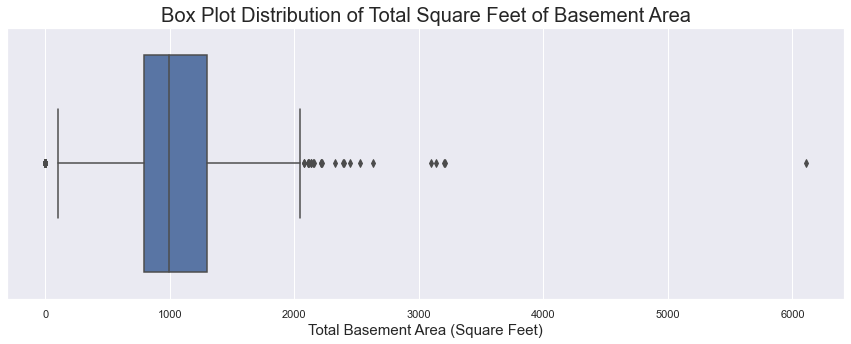

In [2168]:
plot_box_plot_from_series(data=raw_data.TotalBsmtSF,
                          plot_title='Box Plot Distribution of Total Square Feet of Basement Area', 
                          x_axis_label='Total Basement Area (Square Feet)')

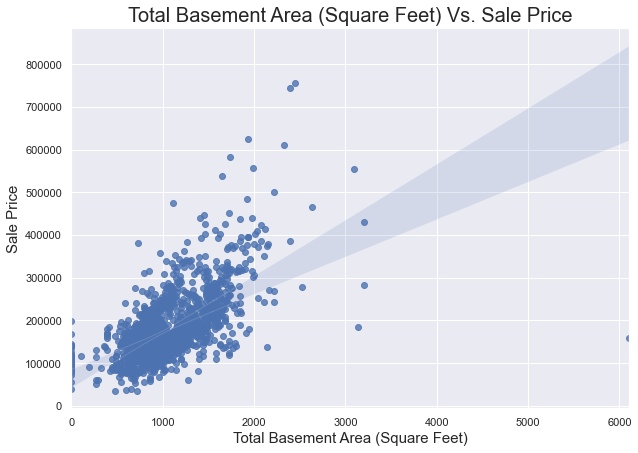

In [2169]:
plot_reg_graph_from_series(x_data=raw_data.TotalBsmtSF, y_data=raw_data.SalePrice,
                           plot_title='Total Basement Area (Square Feet) Vs. Sale Price',
                           x_axis_label='Total Basement Area (Square Feet)', y_axis_label='Sale Price')

In [2170]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.TotalBsmtSF, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.61


#### From the above correlation value, we can be clear that Total Basement Area impacts price of the house significantly

### 4.39 Heating Type

In [2171]:
raw_data.Heating.isna().sum()

0

In [2172]:
raw_data.Heating.value_counts(sort=False)

GasA     1420
Grav        7
OthW        2
Wall        4
Floor       1
GasW       18
Name: Heating, dtype: int64

#### For the Heating Type Column, more than 97% of values ares same. We can say that this column will not have enough predictive power
#### Owing to this, we can drop this column

In [2173]:
raw_data = raw_data.drop(columns=['Heating'])

### 4.40 Heating Quality & Condition

In [2174]:
raw_data.HeatingQC.isna().sum()

0

In [2175]:
heating_qc_df = raw_data.HeatingQC.value_counts(sort=False)
heating_qc_df

Ex    734
TA    427
Fa     49
Po      1
Gd    241
Name: HeatingQC, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2176]:
raw_data.HeatingQC = raw_data.HeatingQC.map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})

In [2177]:
raw_data.HeatingQC.value_counts(sort=False)

0      1
1     49
2    427
3    241
4    734
Name: HeatingQC, dtype: int64

#### This variable can be considered as categorical ordinal variable

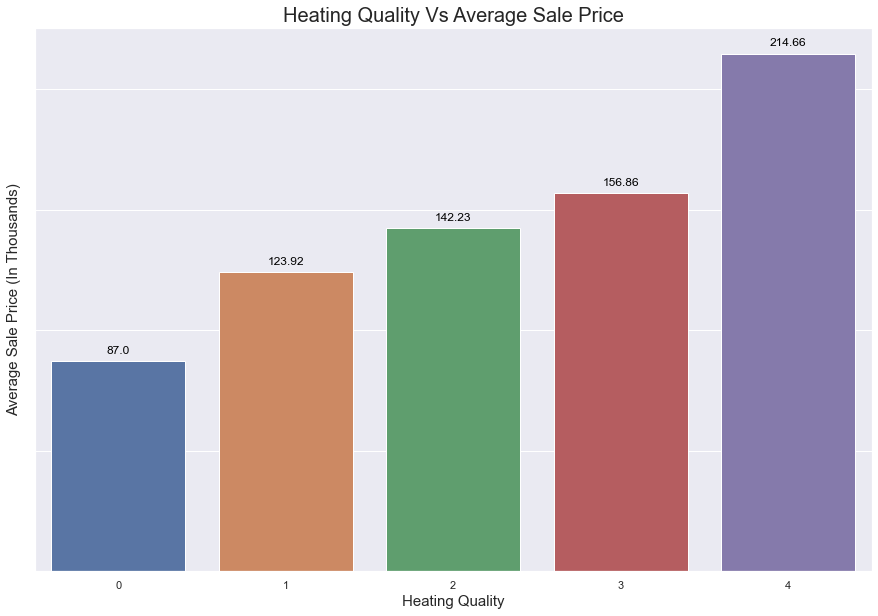

In [2178]:
plot_bar_graph_from_series(data=raw_data.groupby(by='HeatingQC').SalePrice.mean() / 1000,
                           plot_title='Heating Quality Vs Average Sale Price', x_axis_label='Heating Quality',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2179]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.HeatingQC, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.43


#### From the above correlation value, we can be clear that Heating Quality impacts price of the house significantly

### 4.41 Central AC

In [2180]:
raw_data.CentralAir.isna().sum()

0

In [2181]:
central_ac_df = raw_data.CentralAir.value_counts(sort=False)
central_ac_df

N      95
Y    1357
Name: CentralAir, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2182]:
raw_data.CentralAir = raw_data.CentralAir.map({'N': 0, 'Y': 1})

In [2183]:
raw_data.CentralAir.value_counts(sort=False)

0      95
1    1357
Name: CentralAir, dtype: int64

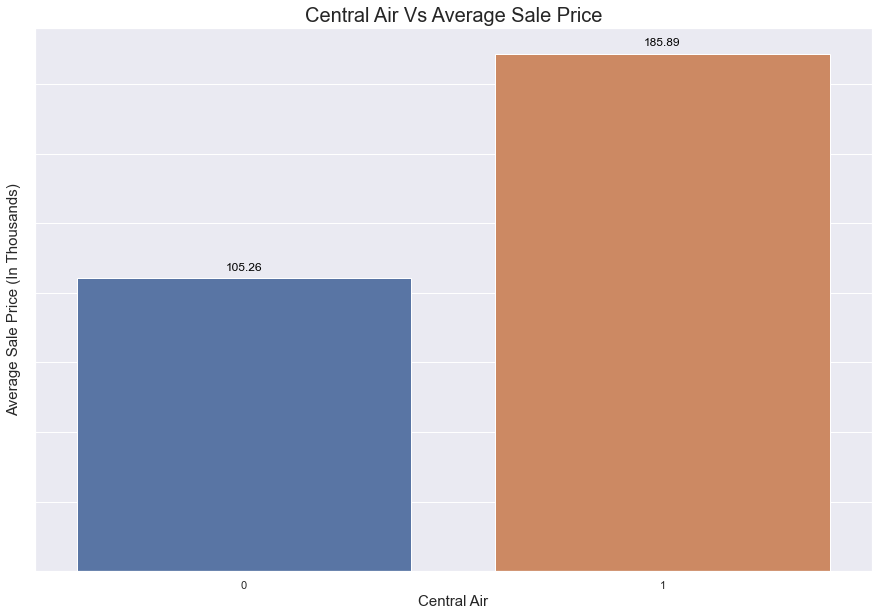

In [2184]:
plot_bar_graph_from_series(data=raw_data.groupby(by='CentralAir').SalePrice.mean() / 1000,
                           plot_title='Central Air Vs Average Sale Price', x_axis_label='Central Air',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2185]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.CentralAir, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.25


#### From the above correlation value, we can be clear that Central Air impacts price of the house significantly

### 4.42 Electrical system

In [2186]:
raw_data.Electrical.isna().sum()

1

In [2187]:
electrical_df = raw_data.Electrical.value_counts(sort=False)
electrical_df

Mix         1
SBrkr    1326
FuseA      94
FuseP       3
FuseF      27
Name: Electrical, dtype: int64

#### Since there is only one value missing in the column, we can drop this row.

In [2188]:
raw_data = raw_data.dropna(subset=['Electrical'])

In [2189]:
raw_data.Electrical.isna().sum()

0

#### Here we can conclude that there are no missing values present in the column

In [2190]:
electrical_df = raw_data.Electrical.value_counts(sort=False)
electrical_df

Mix         1
SBrkr    1326
FuseA      94
FuseP       3
FuseF      27
Name: Electrical, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2191]:
raw_data.Electrical = raw_data.Electrical.map({'Mix': 0, 'FuseP': 1, 'FuseF': 2, 'FuseA': 3, 'SBrkr': 4})

In [2192]:
raw_data.Electrical.value_counts(sort=False)

0       1
1       3
2      27
3      94
4    1326
Name: Electrical, dtype: int64

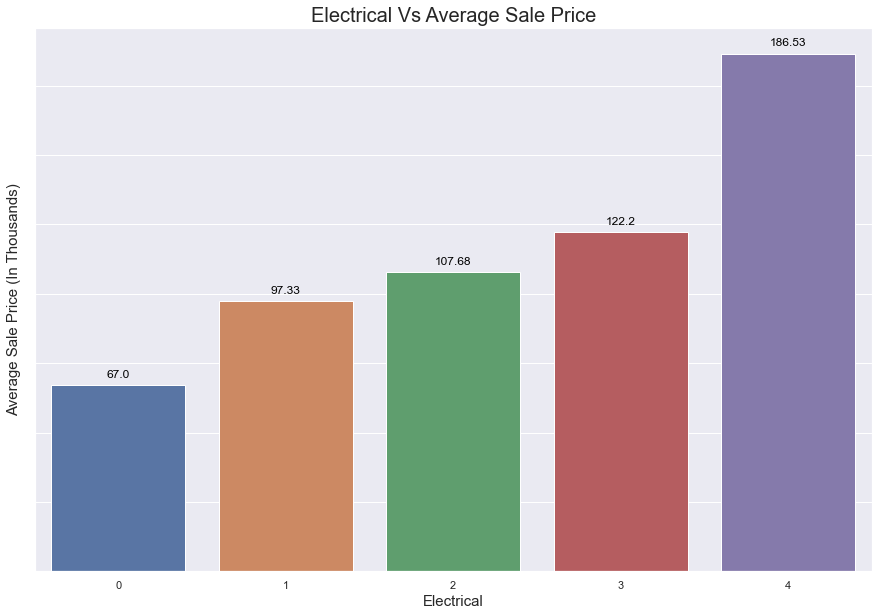

In [2193]:
plot_bar_graph_from_series(data=raw_data.groupby(by='Electrical').SalePrice.mean() / 1000,
                           plot_title='Electrical Vs Average Sale Price', x_axis_label='Electrical',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2194]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.Electrical, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.23


#### From the above correlation value, we can be clear that Electrical Type impacts price of the house significantly

### 4.43 First Floor (Square Feet)

In [2195]:
raw_data['1stFlrSF'].isna().sum()

0

#### This variable can be considered as continuous variable

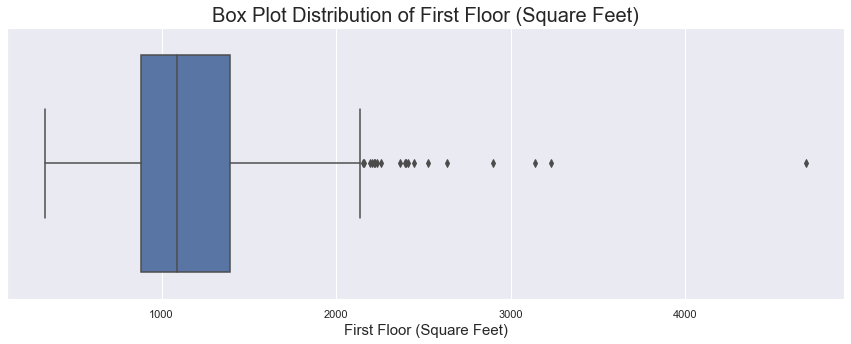

In [2196]:
plot_box_plot_from_series(data=raw_data['1stFlrSF'],
                          plot_title='Box Plot Distribution of First Floor (Square Feet)', 
                          x_axis_label='First Floor (Square Feet)')

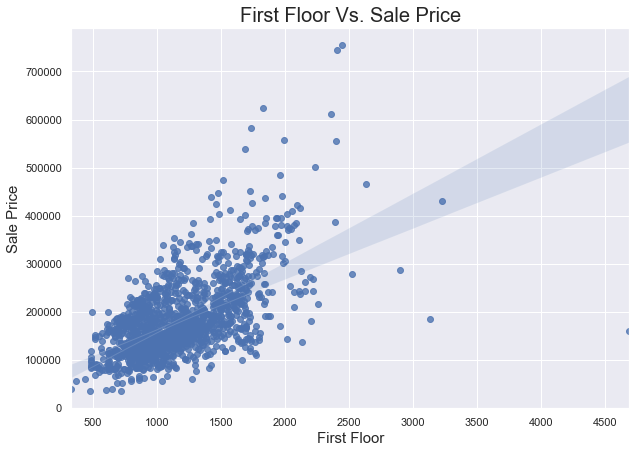

In [2197]:
plot_reg_graph_from_series(x_data=raw_data['1stFlrSF'], y_data=raw_data.SalePrice, plot_title='First Floor Vs. Sale Price',
                           x_axis_label='First Floor', y_axis_label='Sale Price')

In [2198]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data['1stFlrSF'], raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.61


#### From the above correlation value, we can be clear that First Floor Area (Sq Ft) impacts price of the house significantly

### 4.44 Second floor square feet

In [2199]:
raw_data['2ndFlrSF'].isna().sum()

0

#### This variable can be considered as continuous variable

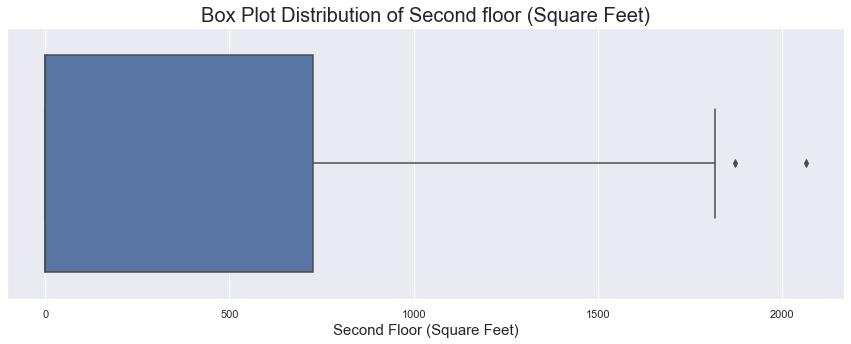

In [2200]:
plot_box_plot_from_series(data=raw_data['2ndFlrSF'],
                          plot_title='Box Plot Distribution of Second floor (Square Feet)', 
                          x_axis_label='Second Floor (Square Feet)')

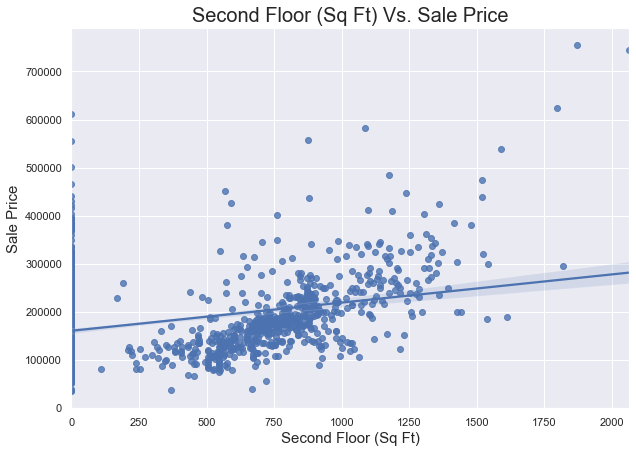

In [2201]:
plot_reg_graph_from_series(x_data=raw_data['2ndFlrSF'], y_data=raw_data.SalePrice, plot_title='Second Floor (Sq Ft) Vs. Sale Price',
                           x_axis_label='Second Floor (Sq Ft)', y_axis_label='Sale Price')

In [2202]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data['2ndFlrSF'], raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.32


#### From the above correlation value, we can be clear that Second Floor (Sq Ft) Area impacts price of the house significantly

### 4.45 Low quality Finished square feet (all floors)

In [2203]:
raw_data['LowQualFinSF'].isna().sum()

0

#### This variable can be considered as continuous variable

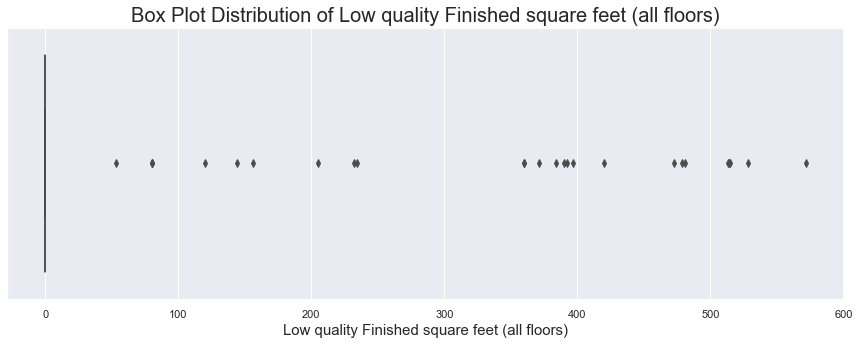

In [2204]:
plot_box_plot_from_series(data=raw_data['LowQualFinSF'],
                          plot_title='Box Plot Distribution of Low quality Finished square feet (all floors)', 
                          x_axis_label='Low quality Finished square feet (all floors)')

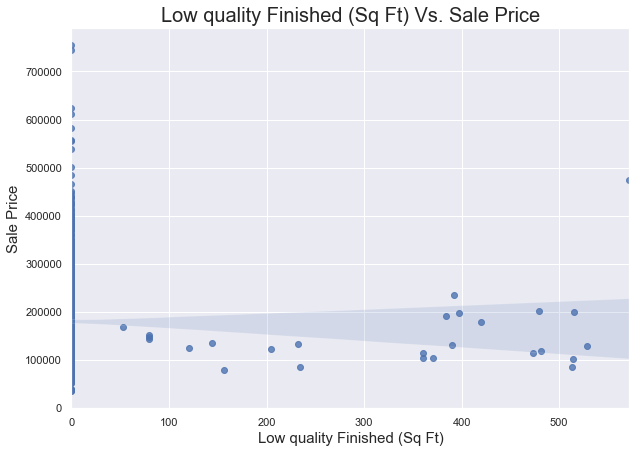

In [2205]:
plot_reg_graph_from_series(x_data=raw_data.LowQualFinSF, y_data=raw_data.SalePrice,
                           plot_title='Low quality Finished (Sq Ft) Vs. Sale Price',
                           x_axis_label='Low quality Finished (Sq Ft)', y_axis_label='Sale Price')

In [2206]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.LowQualFinSF, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.03


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.46 Above grade (ground) living area square feet

In [2207]:
raw_data.GrLivArea.isna().sum()

0

#### This variable can be considered as continuous variable

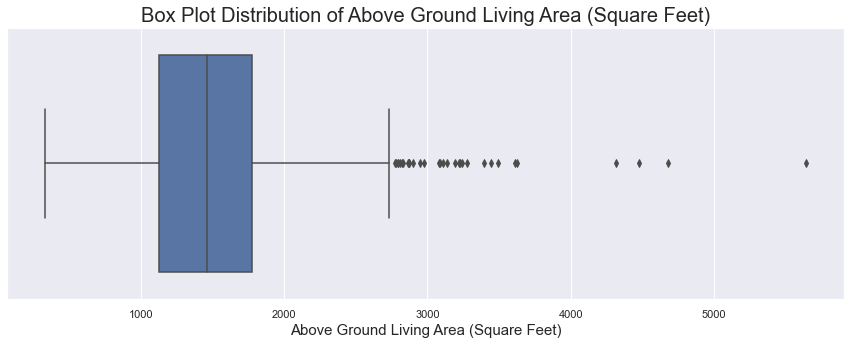

In [2208]:
plot_box_plot_from_series(data=raw_data.GrLivArea,
                          plot_title='Box Plot Distribution of Above Ground Living Area (Square Feet)', 
                          x_axis_label='Above Ground Living Area (Square Feet)')

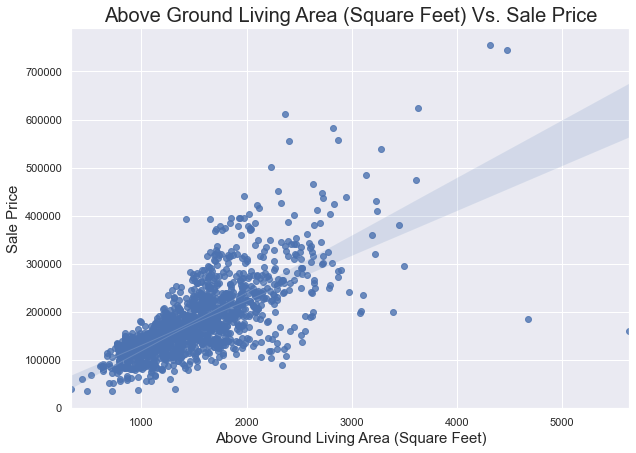

In [2209]:
plot_reg_graph_from_series(x_data=raw_data.GrLivArea, y_data=raw_data.SalePrice,
                           plot_title='Above Ground Living Area (Square Feet) Vs. Sale Price',
                           x_axis_label='Above Ground Living Area (Square Feet)', y_axis_label='Sale Price')

In [2210]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.GrLivArea, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.71


#### From the above correlation value, we can be clear that Above Ground Living Area (Square Feet) impacts price of the house significantly

### 4.47 Basement full bathrooms

In [2211]:
raw_data['BsmtFullBath'].isna().sum()

0

In [2212]:
base_bath_full_df = raw_data.BsmtFullBath.value_counts(sort=False)
base_bath_full_df

0    853
1    582
2     15
3      1
Name: BsmtFullBath, dtype: int64

#### This variable can be considered as categorical ordinal variable

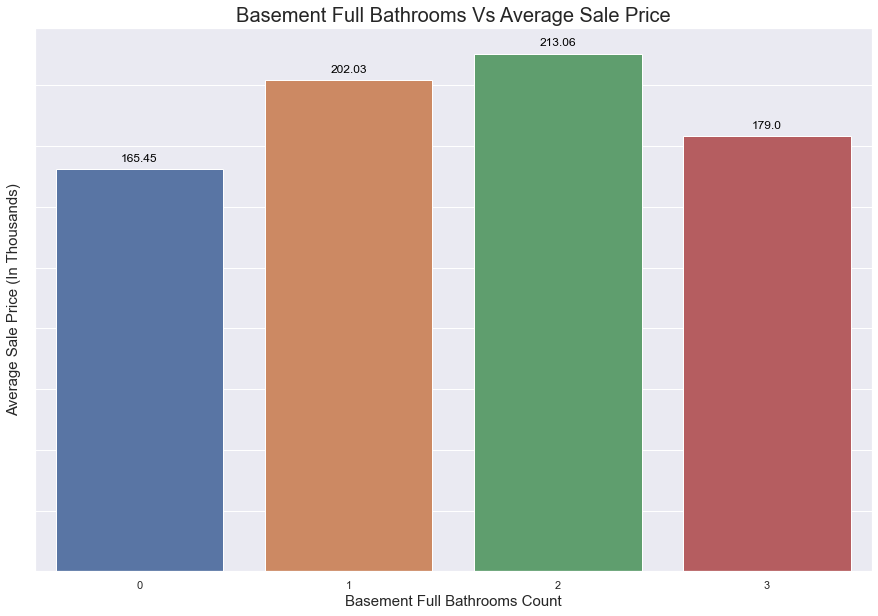

In [2213]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BsmtFullBath').SalePrice.mean() / 1000,
                           plot_title='Basement Full Bathrooms Vs Average Sale Price',
                           x_axis_label='Basement Full Bathrooms Count',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2214]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtFullBath, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.22


#### From the above correlation value, we can be clear that Basement Full Bathrooms Count impacts price of the house significantly

### 4.48 Basement half bathrooms

In [2215]:
raw_data.BsmtHalfBath.isna().sum()

0

In [2216]:
base_bath_half_df = raw_data.BsmtHalfBath.value_counts(sort=False)
base_bath_half_df

0    1369
1      80
2       2
Name: BsmtHalfBath, dtype: int64

#### This variable can be considered as categorical ordinal variable

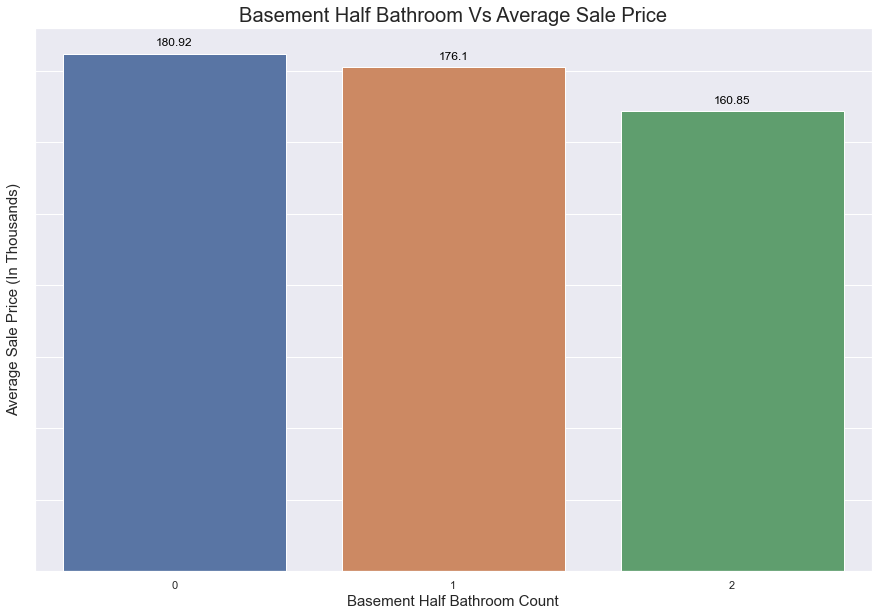

In [2217]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BsmtHalfBath').SalePrice.mean() / 1000,
                           plot_title='Basement Half Bathroom Vs Average Sale Price',
                           x_axis_label='Basement Half Bathroom Count',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2218]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BsmtHalfBath, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.02


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.49 Full bathrooms above grade

In [2219]:
raw_data.FullBath.isna().sum()

0

In [2220]:
full_bath_df = raw_data.FullBath.value_counts(sort=False)
full_bath_df

0      9
1    649
2    761
3     32
Name: FullBath, dtype: int64

#### This variable can be considered as categorical ordinal variable

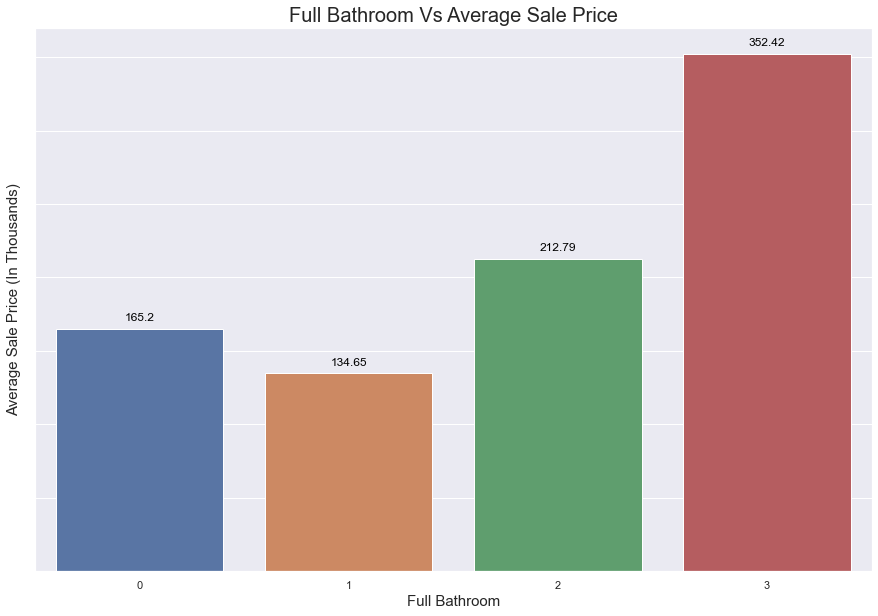

In [2221]:
plot_bar_graph_from_series(data=raw_data.groupby(by='FullBath').SalePrice.mean() / 1000,
                           plot_title='Full Bathroom Vs Average Sale Price', x_axis_label='Full Bathroom',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2222]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.FullBath, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.56


#### From the above correlation value, we can be clear that Full Bathroom Count impacts price of the house significantly

### 4.50 Half baths above grade

In [2223]:
raw_data.HalfBath.isna().sum()

0

In [2224]:
half_bath_df = raw_data.HalfBath.value_counts(sort=False)
half_bath_df

0    910
1    529
2     12
Name: HalfBath, dtype: int64

#### This variable can be considered as categorical ordinal variable

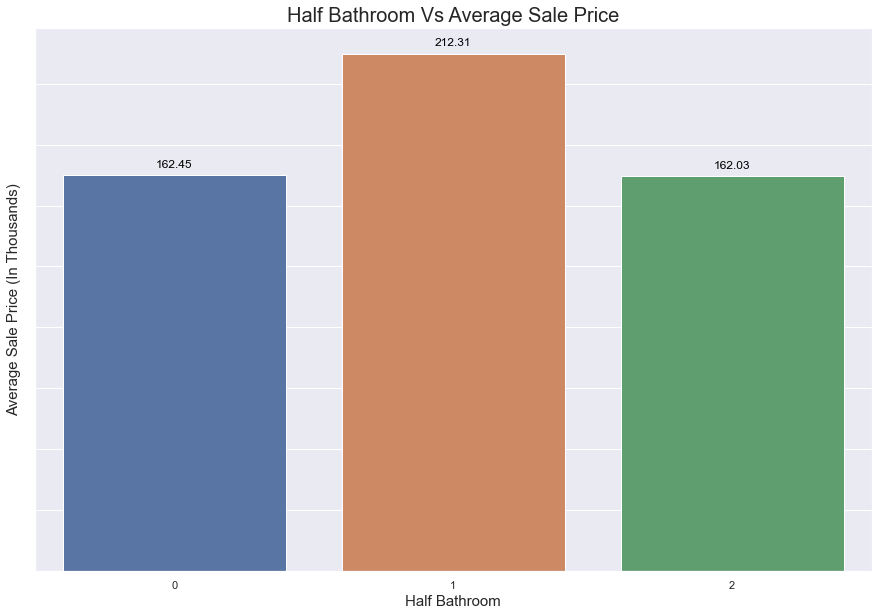

In [2225]:
plot_bar_graph_from_series(data=raw_data.groupby(by='HalfBath').SalePrice.mean() / 1000,
                           plot_title='Half Bathroom Vs Average Sale Price', x_axis_label='Half Bathroom',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2226]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.HalfBath, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.28


#### From the above correlation value, we can be clear that Half Bathroom Count impacts price of the house significantly

### 4.51 Bedrooms above grade (does NOT include basement bedrooms)

In [2227]:
raw_data.BedroomAbvGr.isna().sum()

0

In [2228]:
bed_above_ground_df = raw_data.BedroomAbvGr.value_counts(sort=False)
bed_above_ground_df

0      6
1     49
2    356
3    800
4    211
5     21
6      7
8      1
Name: BedroomAbvGr, dtype: int64

#### This variable can be considered as categorical ordinal variable

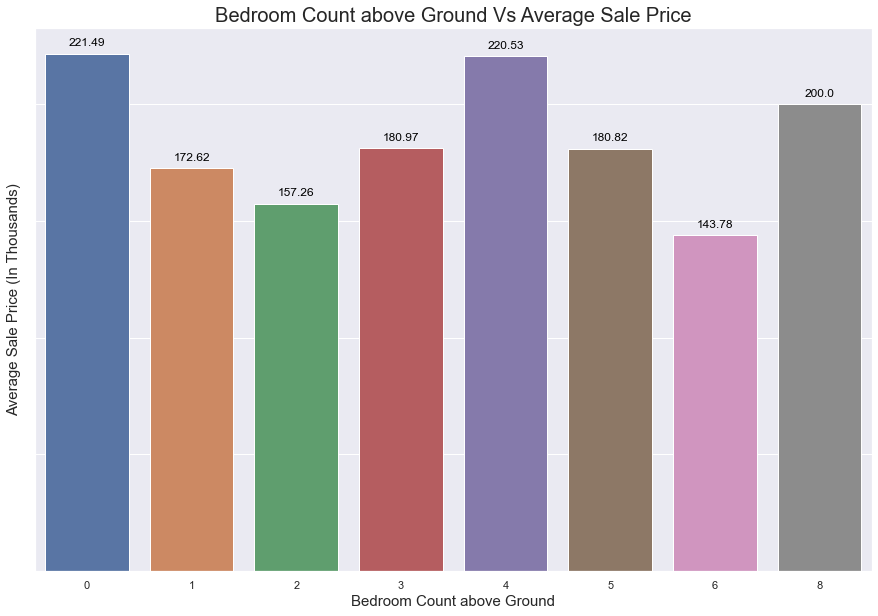

In [2229]:
plot_bar_graph_from_series(data=raw_data.groupby(by='BedroomAbvGr').SalePrice.mean() / 1000,
                           plot_title='Bedroom Count above Ground Vs Average Sale Price',
                           x_axis_label='Bedroom Count above Ground',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2230]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.BedroomAbvGr, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.17


#### From the above correlation value, we can somehow be clear that Bedroom Count above Ground somehow impact price of the house

### 4.52 Kitchens above grade

In [2231]:
raw_data.KitchenAbvGr.isna().sum()

0

In [2232]:
kit_above_ground_df = raw_data.KitchenAbvGr.value_counts(sort=False)
kit_above_ground_df

0       1
1    1384
2      64
3       2
Name: KitchenAbvGr, dtype: int64

#### This variable can be considered as categorical ordinal variable

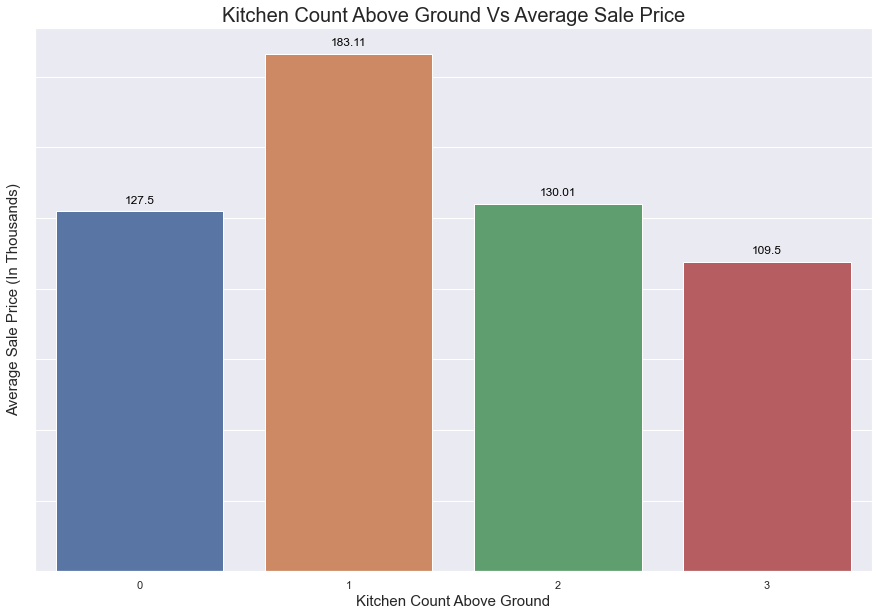

In [2233]:
plot_bar_graph_from_series(data=raw_data.groupby(by='KitchenAbvGr').SalePrice.mean() / 1000,
                           plot_title='Kitchen Count Above Ground Vs Average Sale Price',
                           x_axis_label='Kitchen Count Above Ground',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2234]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.KitchenAbvGr, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.14


#### From the above correlation value, we can somehow be clear that Kitchen Count Above Ground somehow impact price of the house, although in negative way

### 4.53 Kitchen Quality

In [2235]:
raw_data.KitchenQual.isna().sum()

0

In [2236]:
kit_qual_df = raw_data.KitchenQual.value_counts(sort=False)
kit_qual_df

Ex     99
TA    734
Fa     39
Gd    579
Name: KitchenQual, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2237]:
raw_data.KitchenQual = raw_data.KitchenQual.map({'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4})

In [2238]:
raw_data.KitchenQual.value_counts(sort=False)

1     39
2    734
3    579
4     99
Name: KitchenQual, dtype: int64

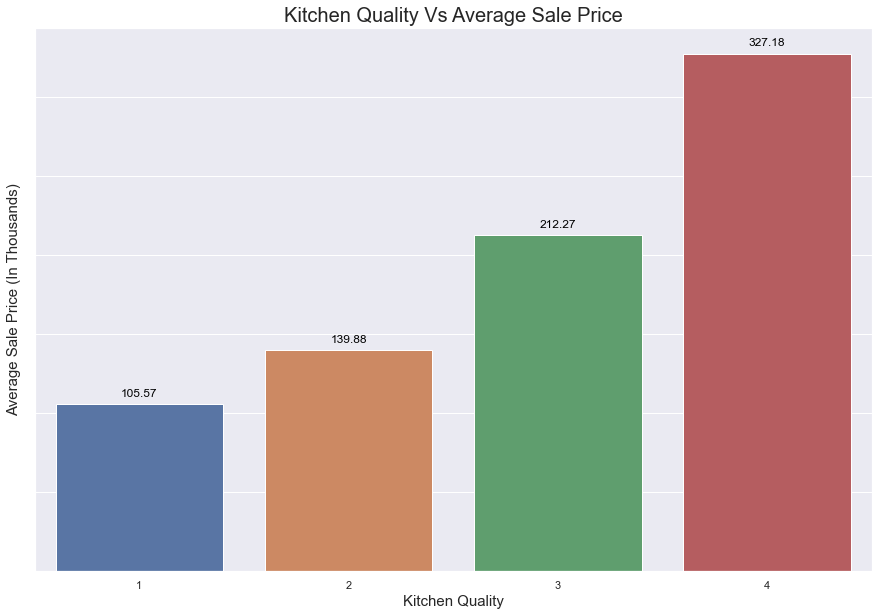

In [2239]:
plot_bar_graph_from_series(data=raw_data.groupby(by='KitchenQual').SalePrice.mean() / 1000,
                           plot_title='Kitchen Quality Vs Average Sale Price', x_axis_label='Kitchen Quality',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2240]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.KitchenQual, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.66


#### From the above correlation value, we can be clear that Kitchen Quality impacts price of the house significantly

### 4.54 Total Rooms Above Ground

In [2241]:
raw_data.TotRmsAbvGrd.isna().sum()

0

In [2242]:
tot_room_abv_grnd_df = raw_data.TotRmsAbvGrd.value_counts(sort=False)
tot_room_abv_grnd_df

2       1
3      17
4      96
5     274
6     401
7     325
8     186
9      74
10     47
11     18
12     11
14      1
Name: TotRmsAbvGrd, dtype: int64

#### This variable can be considered as categorical ordinal variable

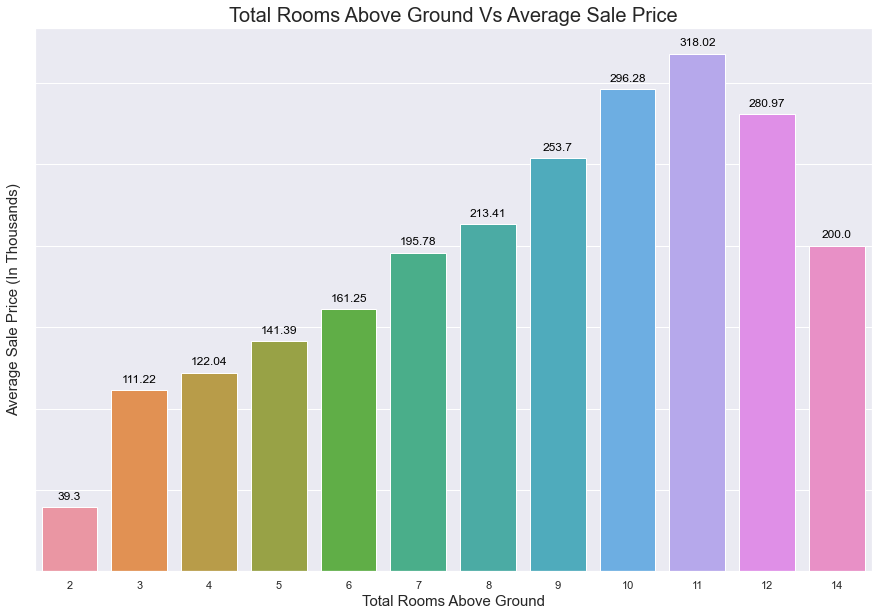

In [2243]:
plot_bar_graph_from_series(data=raw_data.groupby(by='TotRmsAbvGrd').SalePrice.mean() / 1000,
                           plot_title='Total Rooms Above Ground Vs Average Sale Price',
                           x_axis_label='Total Rooms Above Ground',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2244]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.TotRmsAbvGrd, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.54


#### From the above correlation value, we can be clear that Total Rooms Above Ground impacts price of the house significantly

### 4.55 Home Functionality

In [2245]:
raw_data.Functional.isna().sum()

0

In [2246]:
func_df = raw_data.Functional.value_counts(sort=False)
func_df

Min2      34
Maj2       5
Mod       15
Maj1      13
Min1      31
Typ     1352
Sev        1
Name: Functional, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2247]:
raw_data.Functional = raw_data.Functional.map({'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6,
                                                 'Typ': 7})

In [2248]:
raw_data.Functional.value_counts(sort=False)

1       1
2       5
3      13
4      15
5      34
6      31
7    1352
Name: Functional, dtype: int64

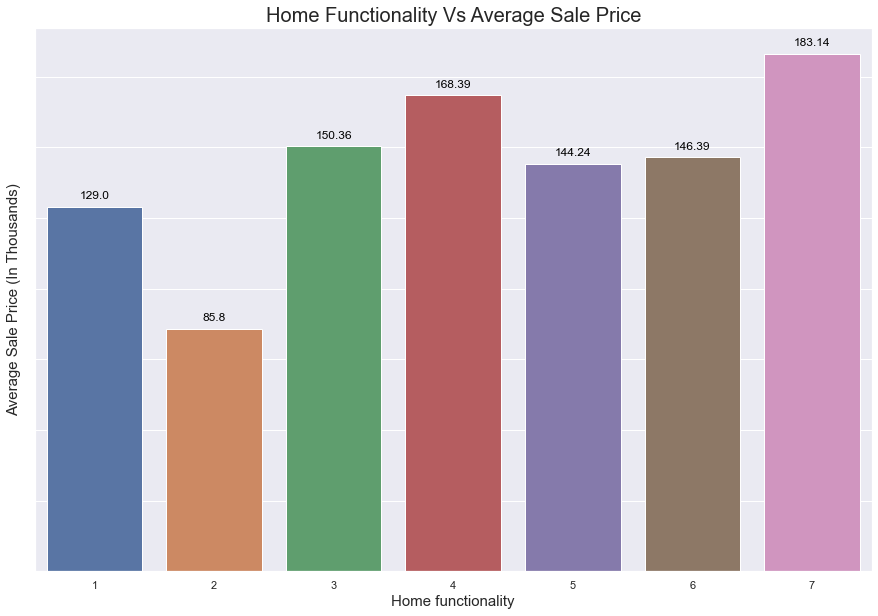

In [2249]:
plot_bar_graph_from_series(data=raw_data.groupby(by='Functional').SalePrice.mean() / 1000,
                           plot_title='Home Functionality Vs Average Sale Price', x_axis_label='Home functionality',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2250]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.Functional, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.11


#### From the above correlation value, we can somehow be clear that Home Functionality somehow impact price of the house

### 4.56 Fireplaces

In [2251]:
raw_data.Fireplaces.isna().sum()

0

#### This variable can be considered as categorical ordinal variable

In [2252]:
fireplaces_df = raw_data.Fireplaces.value_counts(sort=False)
fireplaces_df

0    685
1    648
2    113
3      5
Name: Fireplaces, dtype: int64

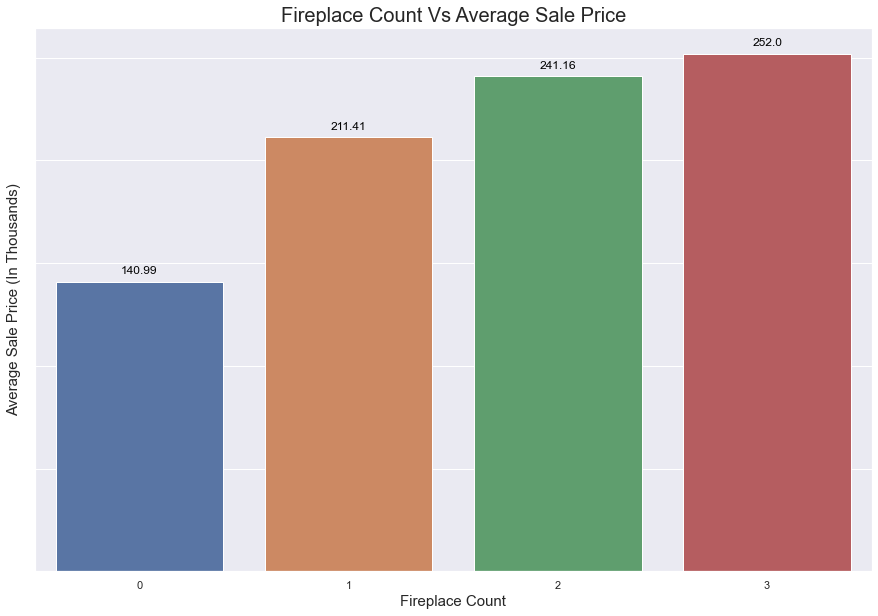

In [2253]:
plot_bar_graph_from_series(data=raw_data.groupby(by='Fireplaces').SalePrice.mean() / 1000,
                           plot_title='Fireplace Count Vs Average Sale Price', x_axis_label='Fireplace Count',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2254]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.Fireplaces, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.47


#### From the above correlation value, we can be clear that Fireplace Count impacts price of the house significantly

### 4.57 Fireplaces Quality

In [2255]:
raw_data.FireplaceQu.isna().sum()

685

In [2256]:
fireplace_qual_df = raw_data.FireplaceQu.value_counts(sort=False)
fireplace_qual_df

Ex     24
TA    311
Fa     33
Po     20
Gd    378
Name: FireplaceQu, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

#### None values are imputed as -1, because data dictionary states that null value corresponds to no fireplace due to which this value is not applicable. Therefore isntead of imputing 0, we will impute -1

In [2257]:
raw_data.FireplaceQu = raw_data.FireplaceQu.map({np.nan: -1, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [2258]:
raw_data.FireplaceQu.value_counts(sort=False)

-1    685
 1     20
 2     33
 3    311
 4    378
 5     24
Name: FireplaceQu, dtype: int64

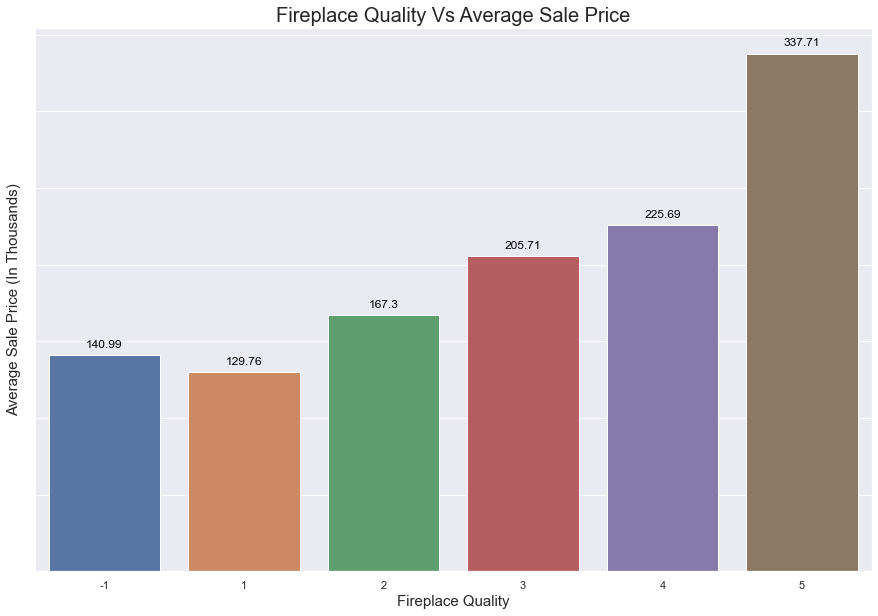

In [2259]:
plot_bar_graph_from_series(data=raw_data.groupby(by='FireplaceQu').SalePrice.mean() / 1000,
                           plot_title='Fireplace Quality Vs Average Sale Price', x_axis_label='Fireplace Quality',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2260]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.FireplaceQu, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.51


#### From the above correlation value, we can be clear that Fireplace Quality impacts price of the house significantly

### 4.58 Garage Type

In [2261]:
raw_data.GarageType.isna().sum()

81

In [2262]:
gar_type_df = raw_data.GarageType.value_counts(sort=False)
gar_type_df

CarPort      9
Basment     19
2Types       6
BuiltIn     86
Attchd     863
Detchd     387
Name: GarageType, dtype: int64

#### This variable can be considered as categorical ordinal variable

#### None values are imputed as -1, because data dictionary states that null value corresponds to no Garage due to which this value is not applicable. Therefore instead of imputing 0, we will impute -1

In [2263]:
raw_data.GarageType = raw_data.GarageType.map({np.nan: -1, 'Detchd': 1, 'CarPort': 2, 'BuiltIn': 3, 'Basment': 4, 'Attchd': 5, '2Types': 6})

In [2264]:
raw_data.GarageType.value_counts(sort=False)

-1     81
 1    387
 2      9
 3     86
 4     19
 5    863
 6      6
Name: GarageType, dtype: int64

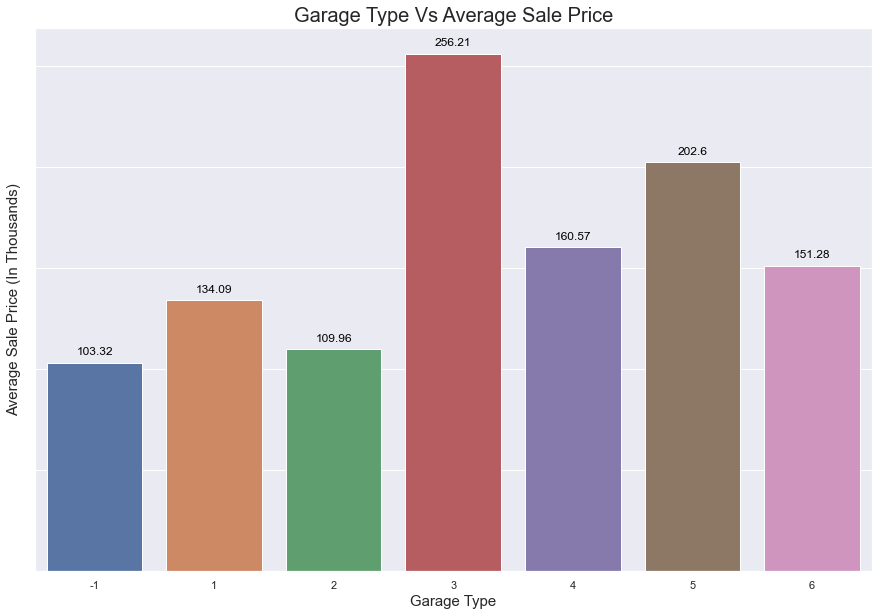

In [2265]:
plot_bar_graph_from_series(data=raw_data.groupby(by='GarageType').SalePrice.mean() / 1000,
                           plot_title='Garage Type Vs Average Sale Price', x_axis_label='Garage Type',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2266]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.GarageType, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.42


#### From the above correlation value, we can be clear that Garage Type impacts price of the house significantly

### 4.59 Garage Built

In [2267]:
raw_data.GarageYrBlt.isna().sum()

81

#### This variable can be considered as continuous variable

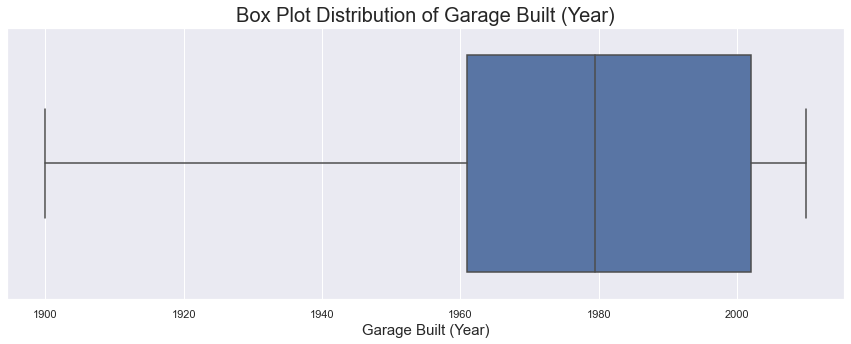

In [2268]:
plot_box_plot_from_series(data=raw_data[~raw_data.GarageYrBlt.isna()].GarageYrBlt,
                          plot_title='Box Plot Distribution of Garage Built (Year)', 
                          x_axis_label='Garage Built (Year)')

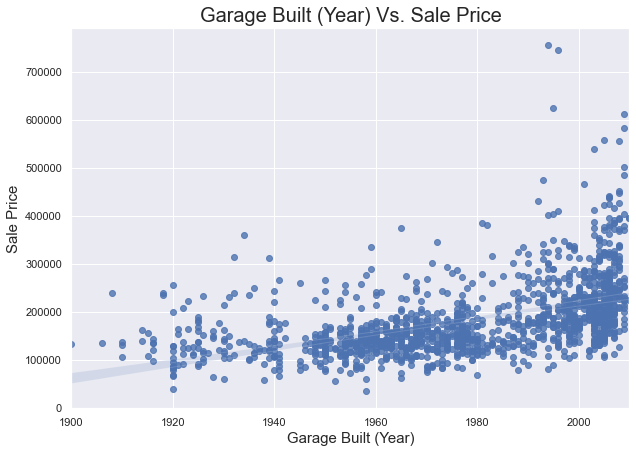

In [2269]:
plot_reg_graph_from_series(x_data=raw_data.GarageYrBlt, y_data=raw_data.SalePrice,
                           plot_title='Garage Built (Year) Vs. Sale Price',
                           x_axis_label='Garage Built (Year)', y_axis_label='Sale Price')

In [2270]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data[~raw_data.GarageYrBlt.isna()].GarageYrBlt,
                                                 raw_data[~raw_data.GarageYrBlt.isna()].SalePrice)[0,1])

Pearsons Correlation: 0.49


### 3.60 Garage Finish

In [2271]:
raw_data.GarageFinish.isna().sum()

81

In [2272]:
gar_fin_df = raw_data.GarageFinish.value_counts(sort=False)
gar_fin_df

Unf    605
Fin    347
RFn    418
Name: GarageFinish, dtype: int64

#### This variable can be considered as categorical ordinal variable

#### None values are imputed as -1, because data dictionary states that null value corresponds to no Garage due to which this value is not applicable. Therefore instead of imputing 0, we will impute -1

In [2273]:
raw_data.GarageFinish = raw_data.GarageFinish.map({np.nan: -1, 'Unf': 1, 'RFn': 2, 'Fin': 3})

In [2274]:
raw_data.GarageFinish.value_counts(sort=False)

-1     81
 1    605
 2    418
 3    347
Name: GarageFinish, dtype: int64

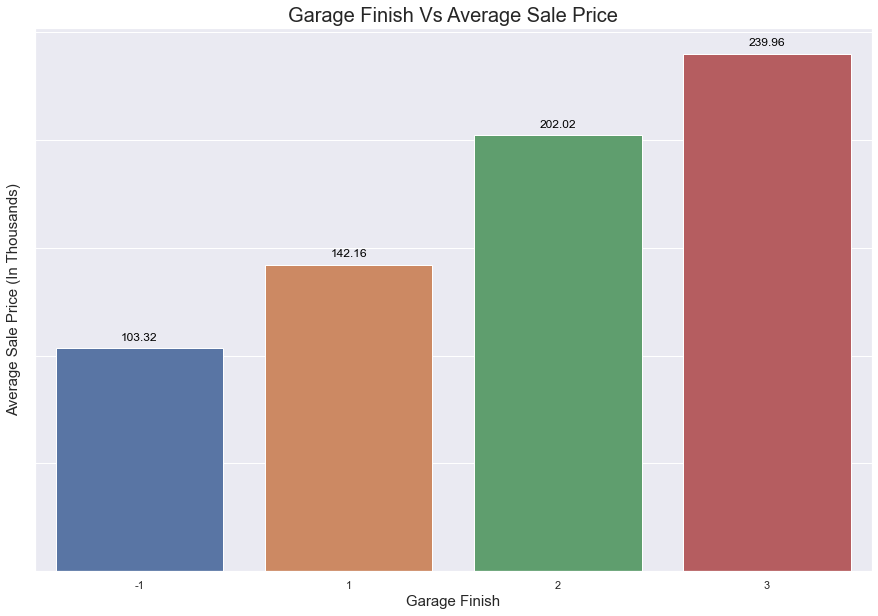

In [2275]:
plot_bar_graph_from_series(data=raw_data.groupby(by='GarageFinish').SalePrice.mean() / 1000,
                           plot_title='Garage Finish Vs Average Sale Price', x_axis_label='Garage Finish',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2276]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.GarageFinish, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.53


#### From the above correlation value, we can be clear that Garage Finish Type impacts price of the house significantly

### 4.61 Garage Cars

In [2277]:
raw_data.GarageCars.isna().sum()

0

In [2278]:
raw_data.GarageCars.value_counts(sort=False)

0     81
1    369
2    816
3    180
4      5
Name: GarageCars, dtype: int64

#### This variable can be considered as categorical ordinal variable

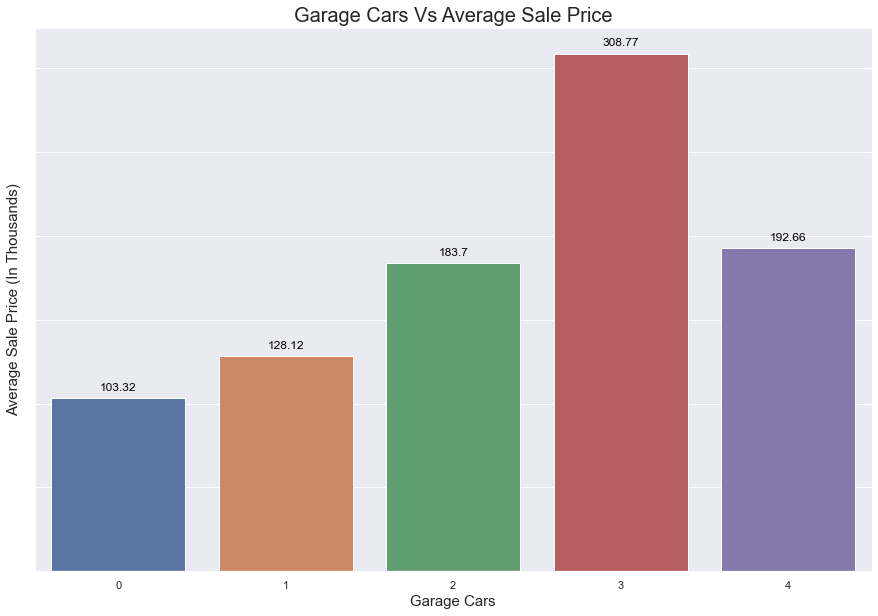

In [2279]:
plot_bar_graph_from_series(data=raw_data.groupby(by='GarageCars').SalePrice.mean() / 1000,
                           plot_title='Garage Cars Vs Average Sale Price', x_axis_label='Garage Cars',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2280]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.GarageCars, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.64


#### From the above correlation value, we can be clear that Garage Cars impacts price of the house significantly

### 4.62 Garage Area

In [2281]:
raw_data.GarageArea.isna().sum()

0

#### This variable can be considered as continuous variable

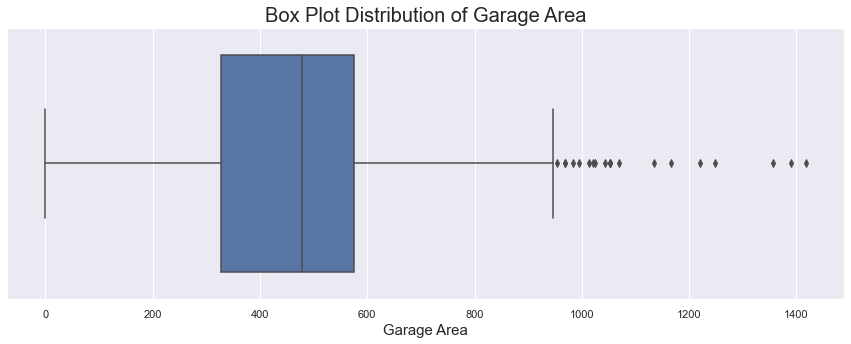

In [2282]:
plot_box_plot_from_series(data=raw_data.GarageArea,
                          plot_title='Box Plot Distribution of Garage Area', 
                          x_axis_label='Garage Area')

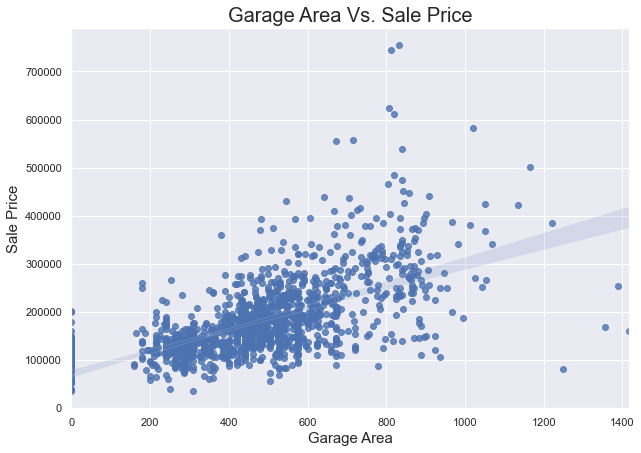

In [2283]:
plot_reg_graph_from_series(x_data=raw_data.GarageArea, y_data=raw_data.SalePrice, plot_title='Garage Area Vs. Sale Price',
                           x_axis_label='Garage Area', y_axis_label='Sale Price')

In [2284]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.GarageArea, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.62


#### From the above correlation value, we can be clear that Garage Area impacts price of the house significantly

### 4.63 Garage Quality

In [2285]:
raw_data.GarageQual.isna().sum()

81

In [2286]:
gar_qual_df = raw_data.GarageQual.value_counts(sort=False)
gar_qual_df

Ex       3
TA    1302
Fa      48
Po       3
Gd      14
Name: GarageQual, dtype: int64

#### This variable can be considered as categorical ordinal variable

#### None values are imputed as -1, because data dictionary states that null value corresponds to no Garage due to which this value is not applicable. Therefore instead of imputing 0, we will impute -1

In [2287]:
raw_data.GarageQual = raw_data.GarageQual.map({np.nan: -1, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [2288]:
raw_data.GarageQual.value_counts(sort=False)

-1      81
 1       3
 2      48
 3    1302
 4      14
 5       3
Name: GarageQual, dtype: int64

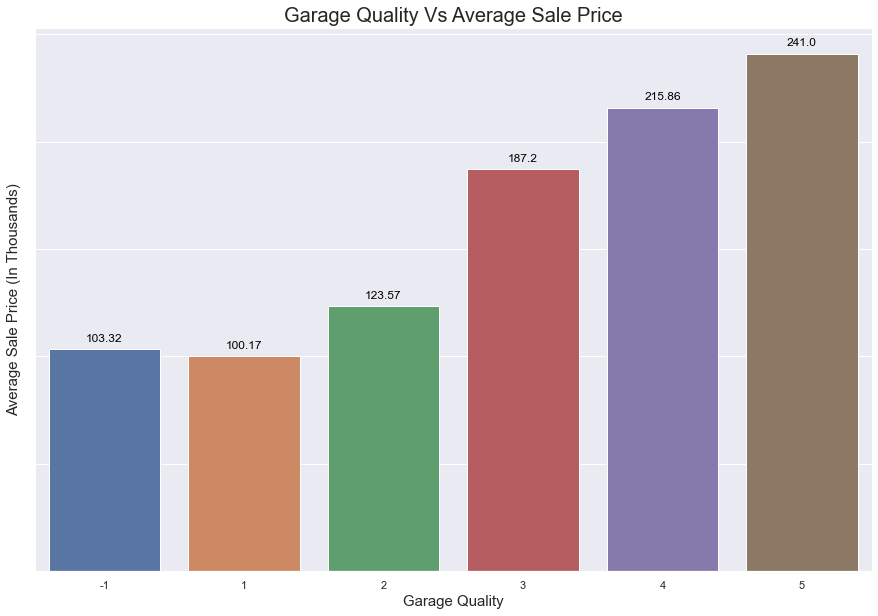

In [2289]:
plot_bar_graph_from_series(data=raw_data.groupby(by='GarageQual').SalePrice.mean() / 1000,
                           plot_title='Garage Quality Vs Average Sale Price', x_axis_label='Garage Quality',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2290]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.GarageQual, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.27


#### From the above correlation value, we can be clear that Garage Quality impacts price of the house significantly

### 4.64 Garage Condition

In [2291]:
raw_data.GarageCond.isna().sum()

81

In [2292]:
gar_cond_df = raw_data.GarageCond.value_counts(sort=False)
gar_cond_df

Ex       2
TA    1317
Fa      35
Po       7
Gd       9
Name: GarageCond, dtype: int64

#### This variable can be considered as categorical ordinal variable

#### None values are imputed as -1, because data dictionary states that null value corresponds to no Garage due to which this value is not applicable. Therefore instead of imputing 0, we will impute -1

In [2293]:
raw_data.GarageCond = raw_data.GarageCond.map({np.nan: -1, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})

In [2294]:
raw_data.GarageCond.value_counts(sort=False)

-1      81
 1       7
 2      35
 3    1317
 4       9
 5       2
Name: GarageCond, dtype: int64

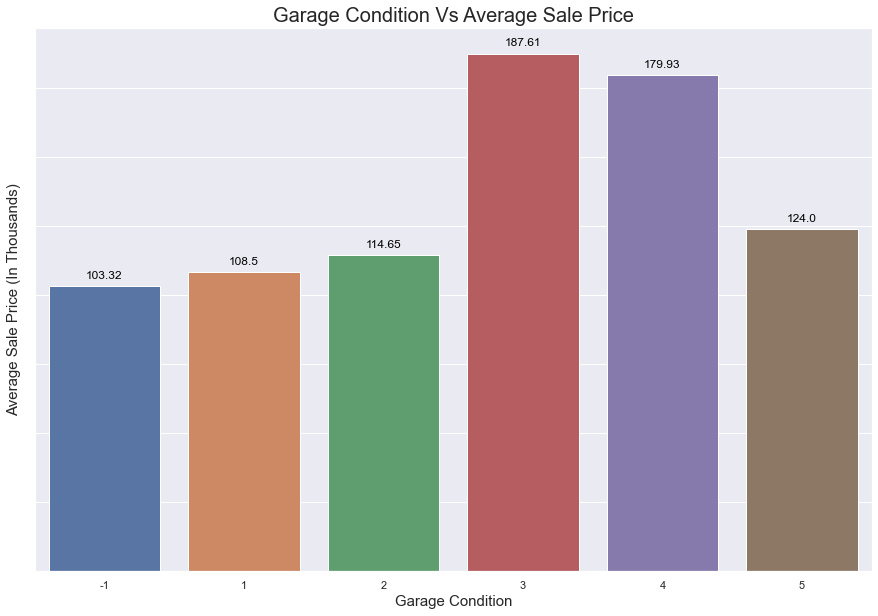

In [2295]:
plot_bar_graph_from_series(data=raw_data.groupby(by='GarageCond').SalePrice.mean() / 1000,
                           plot_title='Garage Condition Vs Average Sale Price', x_axis_label='Garage Condition',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2296]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.GarageCond, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.26


#### From the above correlation value, we can be clear that Garage Condition impacts price of the house significantly

### 4.65 Paved Driveway

In [2297]:
raw_data.PavedDrive.isna().sum()

0

In [2298]:
pave_drive_df = raw_data.PavedDrive.value_counts(sort=False)
pave_drive_df

N      90
P      30
Y    1331
Name: PavedDrive, dtype: int64

#### Being a categorical ordinal variable, following values will be imputed

In [2299]:
raw_data.PavedDrive = raw_data.PavedDrive.map({'N': 0, 'P': 1, 'Y': 2})

In [2300]:
raw_data.PavedDrive.value_counts(sort=False)

0      90
1      30
2    1331
Name: PavedDrive, dtype: int64

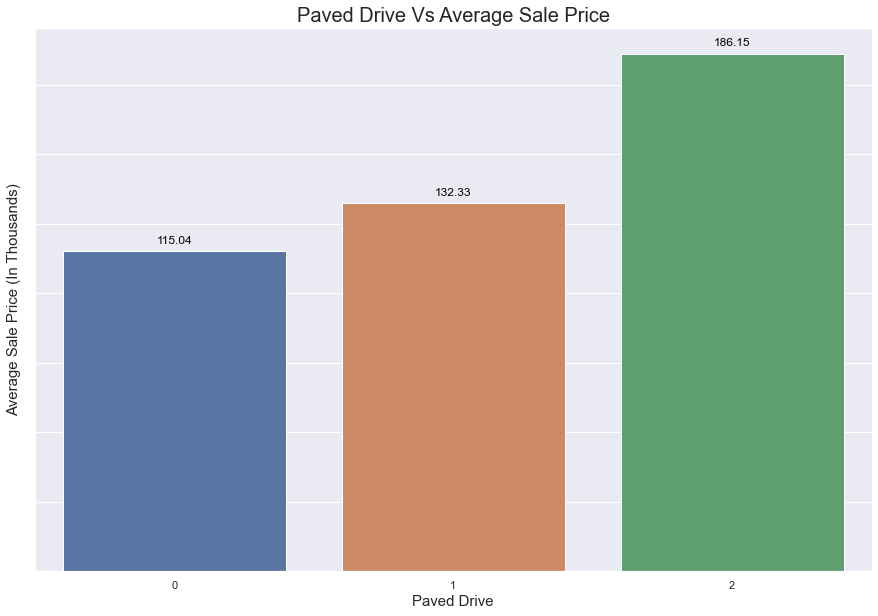

In [2301]:
plot_bar_graph_from_series(data=raw_data.groupby(by='PavedDrive').SalePrice.mean() / 1000,
                           plot_title='Paved Drive Vs Average Sale Price', x_axis_label='Paved Drive',
                           y_axis_label='Average Sale Price (In Thousands)', data_label_rotation='horizontal')

In [2302]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.PavedDrive, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.23


#### From the above correlation value, we can be clear that Paved Drive impacts price of the house significantly

### 4.66 Wood Deck Area (Square Feet)

In [2303]:
raw_data.WoodDeckSF.isna().sum()

0

#### This variable can be considered as continuous variable

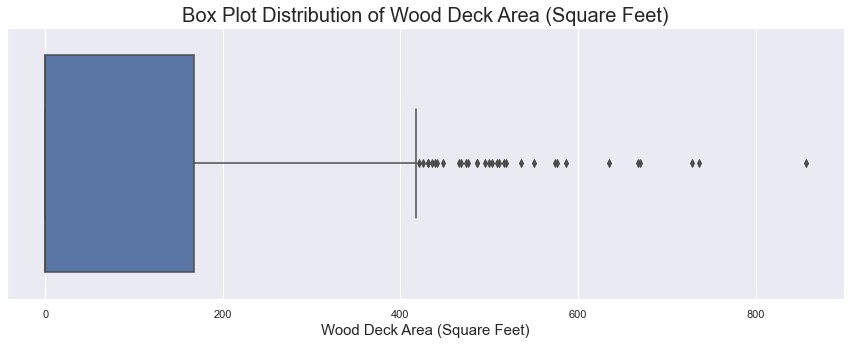

In [2304]:
plot_box_plot_from_series(data=raw_data.WoodDeckSF,
                          plot_title='Box Plot Distribution of Wood Deck Area (Square Feet)', 
                          x_axis_label='Wood Deck Area (Square Feet)')

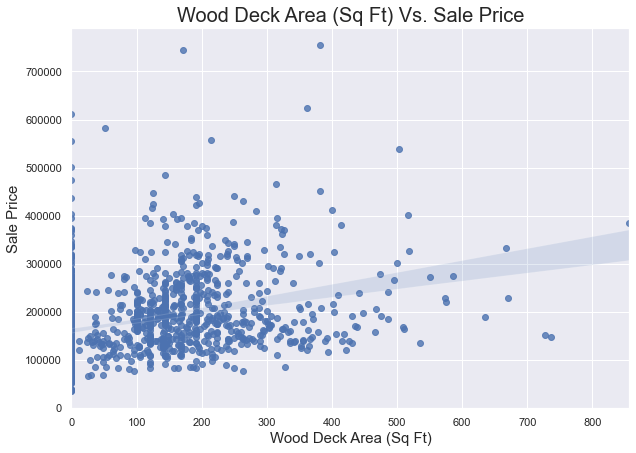

In [2305]:
plot_reg_graph_from_series(x_data=raw_data.WoodDeckSF, y_data=raw_data.SalePrice,
                           plot_title='Wood Deck Area (Sq Ft) Vs. Sale Price',
                           x_axis_label='Wood Deck Area (Sq Ft)', y_axis_label='Sale Price')

In [2306]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.WoodDeckSF, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.32


#### From the above correlation value, we can be clear that Wood Deck Area (Sq Ft) impacts price of the house significantly

### 4.67 Open Porch Area (Square Feet)

In [2307]:
raw_data.OpenPorchSF.isna().sum()

0

#### This variable can be considered as continuous variable

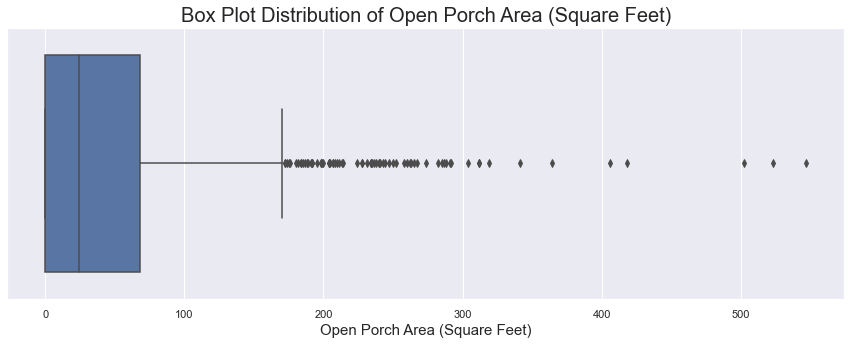

In [2308]:
plot_box_plot_from_series(data=raw_data.OpenPorchSF,
                          plot_title='Box Plot Distribution of Open Porch Area (Square Feet)', 
                          x_axis_label='Open Porch Area (Square Feet)')

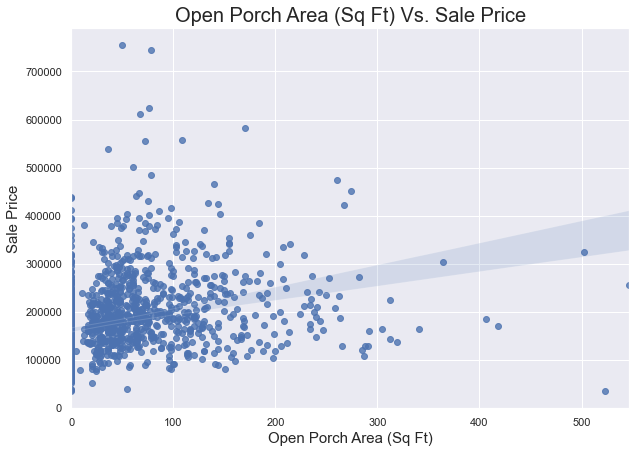

In [2309]:
plot_reg_graph_from_series(x_data=raw_data.OpenPorchSF, y_data=raw_data.SalePrice,
                           plot_title='Open Porch Area (Sq Ft) Vs. Sale Price',
                           x_axis_label='Open Porch Area (Sq Ft)', y_axis_label='Sale Price')

In [2310]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.OpenPorchSF, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.31


#### From the above correlation value, we can be clear that Open Porch Area (Sq Ft) impacts price of the house significantly

### 4.68 Enclosed Porch Area (Square Feet)

In [2311]:
raw_data.EnclosedPorch.isna().sum()

0

#### This variable can be considered as continuous variable

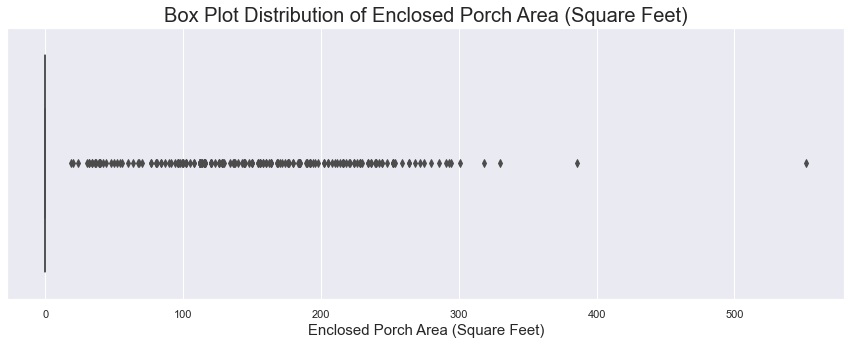

In [2312]:
plot_box_plot_from_series(data=raw_data.EnclosedPorch,
                          plot_title='Box Plot Distribution of Enclosed Porch Area (Square Feet)', 
                          x_axis_label='Enclosed Porch Area (Square Feet)')

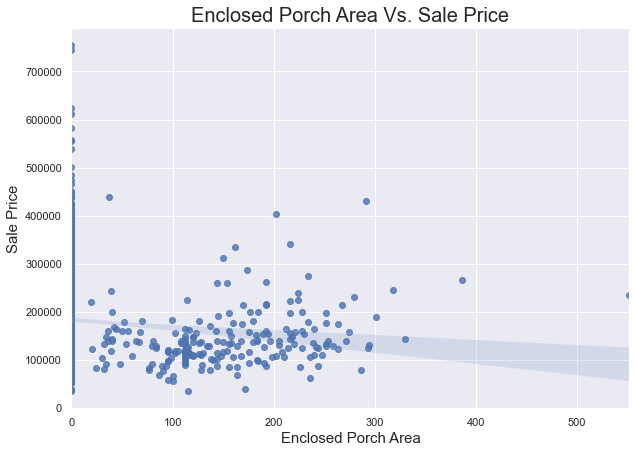

In [2313]:
plot_reg_graph_from_series(x_data=raw_data.EnclosedPorch, y_data=raw_data.SalePrice, plot_title='Enclosed Porch Area Vs. Sale Price',
                           x_axis_label='Enclosed Porch Area', y_axis_label='Sale Price')

In [2314]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.EnclosedPorch, raw_data.SalePrice)[0,1])

Pearsons Correlation: -0.13


#### From the above correlation value, we can somehow be clear that Enclosed Porch Area somehow impact price of the house, although in negative way

### 4.69 3 Season Porch Area (Square Feet)

In [2315]:
raw_data['3SsnPorch'].isna().sum()

0

#### This variable can be considered as continuous variable

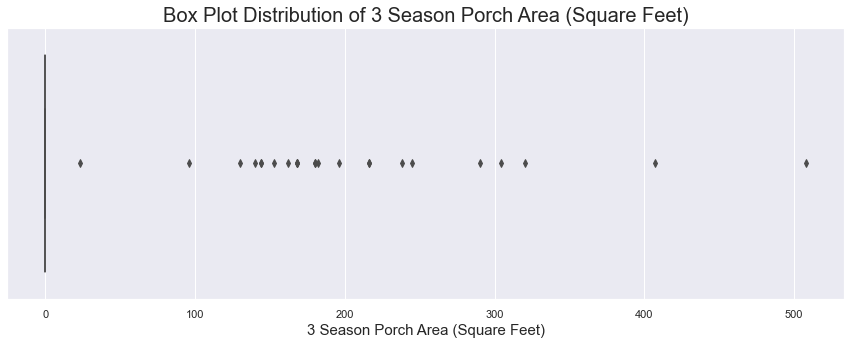

In [2316]:
plot_box_plot_from_series(data=raw_data['3SsnPorch'],
                          plot_title='Box Plot Distribution of 3 Season Porch Area (Square Feet)', 
                          x_axis_label='3 Season Porch Area (Square Feet)')

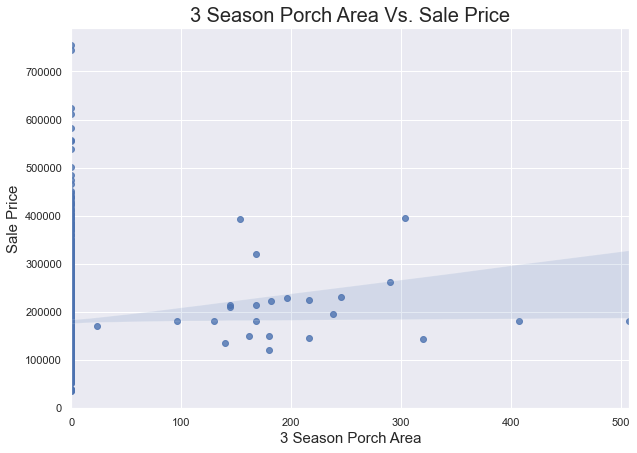

In [2317]:
plot_reg_graph_from_series(x_data=raw_data['3SsnPorch'], y_data=raw_data.SalePrice,
                           plot_title='3 Season Porch Area Vs. Sale Price',
                           x_axis_label='3 Season Porch Area', y_axis_label='Sale Price')

In [2318]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data['3SsnPorch'], raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.05


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.70 Screen Porch Area (Square Feet)

In [2319]:
raw_data.ScreenPorch.isna().sum()

0

#### This variable can be considered as continuous variable

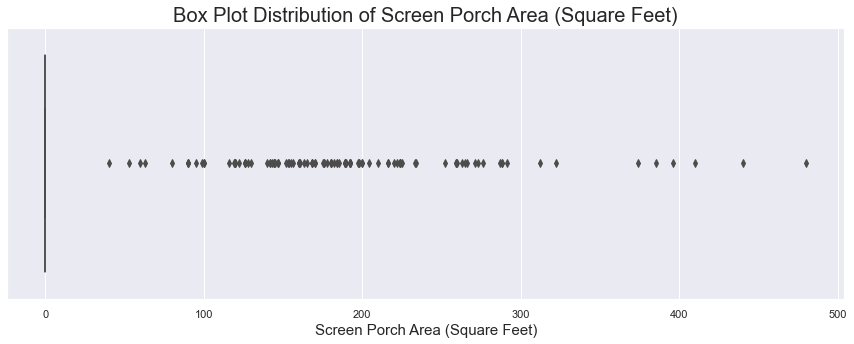

In [2320]:
plot_box_plot_from_series(data=raw_data.ScreenPorch,
                          plot_title='Box Plot Distribution of Screen Porch Area (Square Feet)', 
                          x_axis_label='Screen Porch Area (Square Feet)')

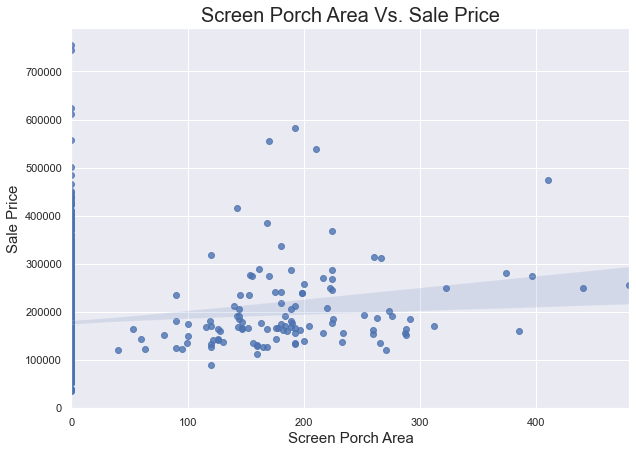

In [2321]:
plot_reg_graph_from_series(x_data=raw_data.ScreenPorch, y_data=raw_data.SalePrice,
                           plot_title='Screen Porch Area Vs. Sale Price',
                           x_axis_label='Screen Porch Area', y_axis_label='Sale Price')

In [2322]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.ScreenPorch, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.11


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.71 Pool Area (Square Feet)

In [2323]:
raw_data.PoolArea.isna().sum()

0

#### This variable can be considered as continuous variable

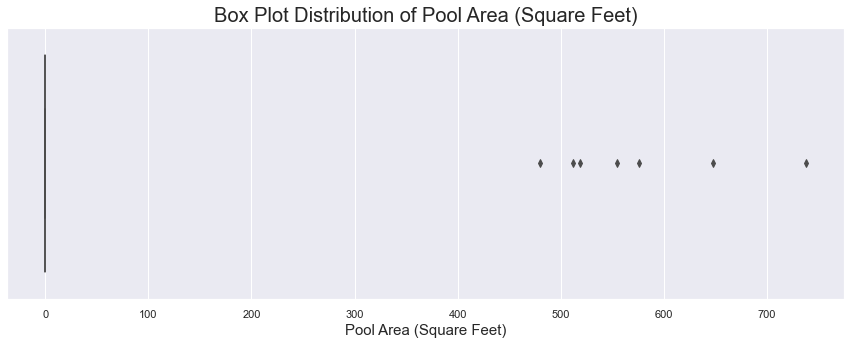

In [2324]:
plot_box_plot_from_series(data=raw_data.PoolArea,
                          plot_title='Box Plot Distribution of Pool Area (Square Feet)', 
                          x_axis_label='Pool Area (Square Feet)')

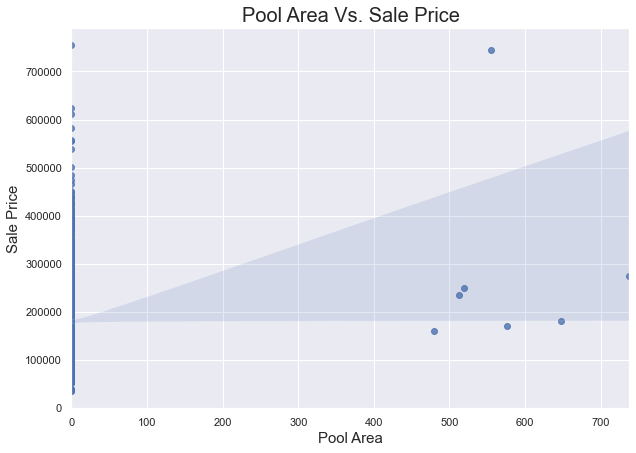

In [2325]:
plot_reg_graph_from_series(x_data=raw_data.PoolArea, y_data=raw_data.SalePrice, plot_title='Pool Area Vs. Sale Price',
                           x_axis_label='Pool Area', y_axis_label='Sale Price')

In [2326]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.PoolArea, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.09


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

### 4.72 Pool Quality

In [2327]:
raw_data.PoolQC.isna().sum()

1444

#### Here, more than 99% values are missing, so we will proceed ahead with dropping this column altogether

In [2328]:
raw_data = raw_data.drop(columns=['PoolQC'])

### 4.73 Fence Quality

In [2329]:
raw_data.Fence.isna().sum()

1170

#### Here, almost 80% values are missing, so we will proceed ahead with dropping this column altogether

In [2330]:
raw_data = raw_data.drop(columns=['Fence'])

### 4.74 Miscellaneous Features

In [2331]:
raw_data.MiscFeature.isna().sum()

1397

#### Here, more than 95% values are missing, so we will proceed ahead with dropping this column altogether

In [2332]:
raw_data = raw_data.drop(columns=['MiscFeature'])

### 4.75 Miscellaneous Features Value

In [2333]:
raw_data.MiscVal.isna().sum()

0

#### In the previous step, Miscellaneous Feature column was dropped since it had many missing values. This column will show values only if the previous column holds value. Since many of the Misc features are not even present, this column wil consist of 0 value to a large extent.
#### Therefore we will proceedd ahead with dropping this column as well

### 4.76 Months & Years Old

In [2334]:
raw_data.MoSold.isna().sum()

0

#### Deriving a new column which will consist of month count by which the property is old

In [2335]:
raw_data['MonthsOld'] = (datetime.now() - pd.to_datetime(raw_data.YrSold.astype(str) + '/' + raw_data.MoSold.astype(str))) //np.timedelta64(1,'M') 

#### This new derived variable can be considered as continuous variable

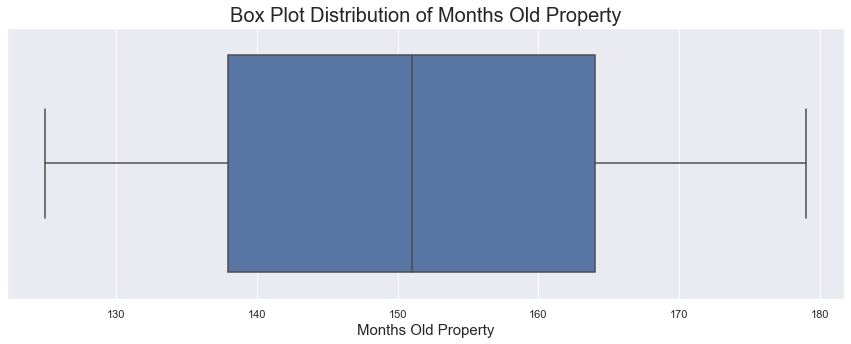

In [2336]:
plot_box_plot_from_series(data=raw_data.MonthsOld,
                          plot_title='Box Plot Distribution of Months Old Property', 
                          x_axis_label='Months Old Property')

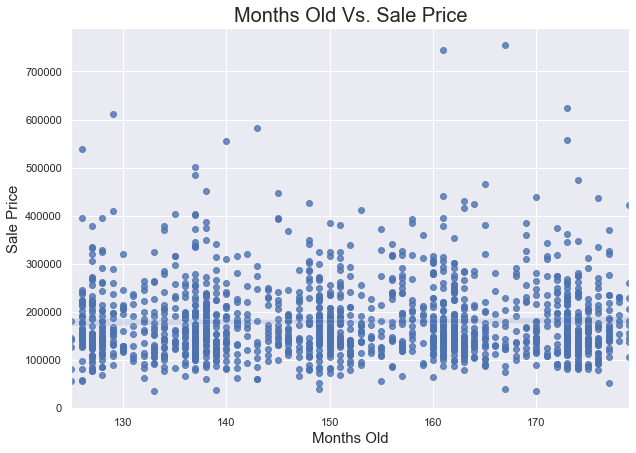

In [2337]:
plot_reg_graph_from_series(x_data=raw_data.MonthsOld, y_data=raw_data.SalePrice, plot_title='Months Old Vs. Sale Price',
                           x_axis_label='Months Old', y_axis_label='Sale Price')

In [2338]:
print('Pearsons Correlation: %.2f' % np.corrcoef(raw_data.MonthsOld, raw_data.SalePrice)[0,1])

Pearsons Correlation: 0.02


#### Correlation Co-efficient of Sale Price with this variable is not strong enough.

#### Also, we can drop the orginal columns of Months & Year, since we have new derived column whcih explains this 2 columns approproately

In [2339]:
raw_data = raw_data.drop(columns=['YrSold', 'MoSold'])

### 4.77 Sale Type

In [2340]:
raw_data.SaleType.isna().sum()

0

In [2341]:
sale_type_df = raw_data.SaleType.value_counts(sort=True)
sale_type_df

WD       1261
New       119
COD        43
ConLD       9
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

#### Sale Type variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

#### In the above variable there are 9 unique values. If we create dummy variable for each of this, it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 3 values and map all other values to 0

In [2342]:
raw_data.SaleType = reduce_variable_categorical_nominal(raw_data.SaleType, 3)

In [2343]:
raw_data.SaleType.value_counts(sort=True)

WD        1261
New        119
COD         43
Others      28
Name: SaleType, dtype: int64

### 4.78 Sale Condition

In [2344]:
raw_data.SaleCondition.isna().sum()

0

#### Sale Condition variable do not hold any order. So, this variable can be used as Categorical Nominal Variable

In [2345]:
sale_cond_df = raw_data.SaleCondition.value_counts(sort=True)
sale_cond_df

Normal     1193
Partial     122
Abnorml     101
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

#### In the above variable there are 6 unique values of which last three are very scarce . We can avoid creating dummy variable for these variables, as it will result in many columns which will increase complexity and dimesnionality of the model.
#### For this, we will encode only top 3 values and map all other values as Others

In [2346]:
raw_data.SaleCondition = reduce_variable_categorical_nominal(raw_data.SaleCondition, 3)
raw_data.SaleCondition.value_counts(sort=True)

Normal     1193
Partial     122
Abnorml     101
Others       35
Name: SaleCondition, dtype: int64

### 4.79 Sale Price

In [2347]:
raw_data.SalePrice.isna().sum()

0

#### This variable can be considered as continuous variable

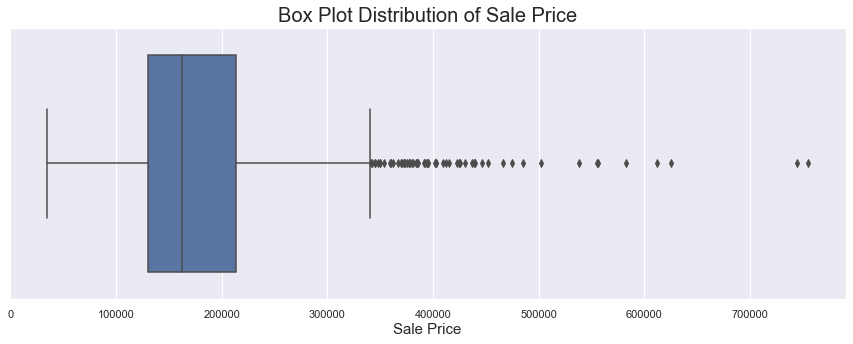

In [2348]:
plot_box_plot_from_series(data=raw_data.SalePrice,
                          plot_title='Box Plot Distribution of Sale Price', 
                          x_axis_label='Sale Price')

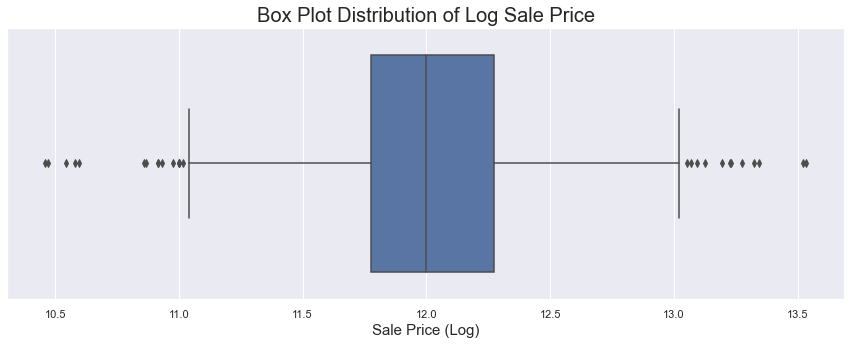

In [2349]:
plot_box_plot_from_series(data=np.log(raw_data.SalePrice),
                          plot_title='Box Plot Distribution of Log Sale Price', 
                          x_axis_label='Sale Price (Log)')

#### On performing log operation, this variable is very much as normally distributed variable

In [2350]:
raw_data['SalePrice'] = np.log(raw_data.SalePrice)

### 4.80 Distributing Variable Types

In [2351]:
raw_data.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Alley', 'LotShape',
       'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'Scr

In [2352]:
continuous_variables = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                        'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
                        'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
                        '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MonthsOld', 'SalePrice']

In [2353]:
categorical_ordinal_variables = ['MSSubClass', 'Alley', 'LotShape', 'LandContour', 'LandSlope', 'OverallQual',
                                 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
                                 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical',
                                 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
                                 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
                                 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual',
                                 'GarageCond', 'PavedDrive']

In [2354]:
categorical_nominal_variables = ['MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle',
                                 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'SaleType',
                                 'SaleCondition']

### 4.81 Identifying Highly Correlated Input Variables

In [2355]:
corr = round(raw_data[categorical_ordinal_variables + continuous_variables].corr(), 2)

In [2356]:
# plt.figure(figsize=(20, 17))
# sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
# plt.show()

In the above heatmap, we see that there are few pairs of input variables showing high correlation value between them
- 1. External Quality / Overall Quality ==> 0.73
- 2. External Quality / Kitchen Quality ==> 0.72
- 3. BsmtFinSF2 / BsmtFinType2 ==> 0.79
- 4. Fireplaces / Fireplace Quality ==> 0.87
- 5. Garage Quality / Garage Condiiton ==> 0.96
- 6. Total Rooms Above Ground / Ground Live Area ==> 0.83
- 7. Total Basement Area / First Floor Area ==> 0.82
- 8. Year Built / Garage Year Built ==> 0.82
- 9. Garage Cars / Garage Area ==> 0.88

#### Therefore, we will proceed ahead with dropping following columns since they show high collinearity with other variables
- 1. External Quality
- 2. Basement 2 Finished Area (Sq Ft)
- 3. Fireplaces
- 4. Garage Condiiton
- 5. Total Rooms Above Ground
- 6. First Floor Area
- 7. Garage Year Built
- 8. Garage Cars

In [2357]:
input_variables_to_be_dropped_1 = ['ExterQual', 'BsmtFinSF2', 'Fireplaces', 'GarageCond', 'TotRmsAbvGrd', '1stFlrSF',
                                   'GarageYrBlt', 'GarageCars']

In [2358]:
raw_data = raw_data.drop(columns=input_variables_to_be_dropped_1)

In [2359]:
for index in input_variables_to_be_dropped_1:
    if index in continuous_variables:
        continuous_variables.remove(index)
    if index in categorical_ordinal_variables:
        categorical_ordinal_variables.remove(index)

In [2360]:
raw_data.shape

(1451, 63)

### 4.82 Dummy Variable Creation for Categorical Nominal Variables

#### 4.82.1 General Zoning Classification

In [2361]:
raw_data.MSZoning.value_counts(sort=True)

RL        1145
RM         218
Others      88
Name: MSZoning, dtype: int64

In [2362]:
raw_data = dummy_variable_create('MSZoning')

#### 4.82.2 Lot configuration

In [2363]:
raw_data.LotConfig.value_counts(sort=True)

Inside     1045
Corner      262
CulDSac      93
Others       51
Name: LotConfig, dtype: int64

In [2364]:
raw_data = dummy_variable_create('LotConfig')

#### 4.82.3 Neighborhood Type

In [2365]:
raw_data.Neighborhood.value_counts(sort=True)

Others     422
NAmes      225
CollgCr    149
OldTown    113
Edwards    100
Somerst     83
Gilbert     78
NridgHt     76
Sawyer      74
NWAmes      73
SawyerW     58
Name: Neighborhood, dtype: int64

In [2366]:
raw_data = dummy_variable_create('Neighborhood', 'SawyerW')

#### 4.82.4 Condition 1

In [2367]:
raw_data.Condition1.value_counts(sort=True)

Norm      1251
Feedr       81
Others      71
Artery      48
Name: Condition1, dtype: int64

In [2368]:
raw_data = dummy_variable_create('Condition1', 'Artery')

#### 4.82.5 Building Type

In [2369]:
raw_data.BldgType.value_counts(sort=True)

1Fam      1212
TwnhsE     113
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [2370]:
raw_data = dummy_variable_create('BldgType', '2fmCon')

#### 4.82.6 House Style

In [2371]:
raw_data.HouseStyle.value_counts(sort=True)

1Story    721
2Story    442
1.5Fin    154
Others    134
Name: HouseStyle, dtype: int64

In [2372]:
raw_data = dummy_variable_create('HouseStyle')

#### 4.82.7 Roof Style

In [2373]:
raw_data.RoofStyle.value_counts(sort=True)

Gable     1133
Hip        285
Others      33
Name: RoofStyle, dtype: int64

In [2374]:
raw_data = dummy_variable_create('RoofStyle')

#### 4.82.8 Exterior (1st) covering on house

In [2375]:
raw_data.Exterior1st.value_counts(sort=True)

VinylSd    509
HdBoard    222
MetalSd    220
Wd Sdng    205
Others     187
Plywood    108
Name: Exterior1st, dtype: int64

In [2376]:
raw_data = dummy_variable_create('Exterior1st')

#### 4.82.9 Exterior (2nd) covering on house

In [2377]:
raw_data.Exterior2nd.value_counts(sort=True)

VinylSd    498
MetalSd    214
HdBoard    207
Wd Sdng    197
Others     193
Plywood    142
Name: Exterior2nd, dtype: int64

In [2378]:
raw_data = dummy_variable_create('Exterior2nd')

#### 4.82.10 Masonry Veneer Type

In [2379]:
raw_data.MasVnrType.value_counts(sort=True)

None       863
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [2380]:
raw_data = dummy_variable_create('MasVnrType', 'BrkCmn')

#### 4.82.11 Foundation Type

In [2381]:
raw_data.Foundation.value_counts(sort=True)

PConc     638
CBlock    634
BrkTil    146
Others     33
Name: Foundation, dtype: int64

In [2382]:
raw_data = dummy_variable_create('Foundation')

#### 4.82.12 Sale Type

In [2383]:
raw_data.SaleType.value_counts(sort=True)

WD        1261
New        119
COD         43
Others      28
Name: SaleType, dtype: int64

In [2384]:
raw_data = dummy_variable_create('SaleType')

#### 4.82.13 Sale Condition

In [2385]:
raw_data.SaleCondition.value_counts(sort=True)

Normal     1193
Partial     122
Abnorml     101
Others       35
Name: SaleCondition, dtype: int64

In [2386]:
raw_data = dummy_variable_create('SaleCondition')

In [2387]:
raw_data.shape

(1451, 99)

# 5. I/O Classification

In [ ]:
y = raw_data.pop('SalePrice')

In [ ]:
X = raw_data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=14)